In [1]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import data_processing, visualization, statistic
import time
import pandas as pd
import warnings
from lifelines import CoxPHFitter
from tableone import TableOne
warnings.filterwarnings("ignore")

In [2]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.compare import compare_survival
from sksurv.nonparametric import kaplan_meier_estimator

from sksurv.util import Surv

In [3]:
%matplotlib inline

### Experiment setting

In [4]:
dataset_name = "gbsg2"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "./dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

In [5]:
gbsb2_control = pd.read_csv(data_file_control,header=None)
gbsb2_control.columns = ['time','censor','age','estrec','menostat','pnodes','progrec','tgrade','tsize']
gbsb2_control.head()

,time,censor,age,estrec,menostat,pnodes,progrec,tgrade,tsize
0,1814.0,1,70.0,66.0,1,3.0,48.0,2,21.0
1,772.0,1,73.0,65.0,1,1.0,26.0,2,35.0
2,448.0,1,32.0,13.0,0,24.0,0.0,3,57.0
3,2161.0,0,65.0,25.0,1,1.0,192.0,2,16.0
4,471.0,1,80.0,59.0,1,30.0,0.0,2,39.0


In [6]:
#gbsb2_control_columns = pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
#gbsb2_control_columns = ['time','censor'] + gbsb2_control_columns
#gbsb2_control_columns

In [7]:
gbsb2_control_columns = pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
gbsb2_control_columns.insert(0, 'censor')
gbsb2_control_columns.insert(0, 'time')
gbsb2_control_columns

['time',
 'censor',
 'age',
 'estrec',
 'menostat',
 'pnodes',
 'progrec',
 'tgrade',
 'tsize']

### Data loading and Feature analysis treated/control

In [8]:
# Load training data
data_control, feat_types_dict, miss_mask_control, true_miss_mask_control, n_samples_control = data_processing.read_data(data_file_control, 
                                                                                                                        feat_types_file_control, 
                                                                                                                        miss_file, true_miss_file)
# Feature analysis
data_transformed_control = data_processing.discrete_variables_transformation(data_control, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

#visualization.plot_data(data_transformed_control, feat_types_dict)


In [9]:
feat_types_dict

[{'name': 'survcens', 'type': 'surv_weibull', 'dim': '2', 'nclass': ''},
 {'name': 'age', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'name': 'estrec', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'menostat', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'pnodes', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'progrec', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'tgrade', 'type': 'cat', 'dim': '1', 'nclass': '3'},
 {'name': 'tsize', 'type': 'pos', 'dim': '1', 'nclass': ''}]

In [10]:
data_transformed_control

tensor([[1.8140e+03, 1.0000e+00, 7.0000e+01,  ..., 4.8000e+01, 1.0000e+00,
         2.1000e+01],
        [7.7200e+02, 1.0000e+00, 7.3000e+01,  ..., 2.6000e+01, 1.0000e+00,
         3.5000e+01],
        [4.4800e+02, 1.0000e+00, 3.2000e+01,  ..., 0.0000e+00, 2.0000e+00,
         5.7000e+01],
        ...,
        [7.6900e+02, 1.0000e+00, 5.1000e+01,  ..., 4.3000e+01, 2.0000e+00,
         2.5000e+01],
        [7.2700e+02, 1.0000e+00, 5.2000e+01,  ..., 1.5000e+01, 1.0000e+00,
         2.3000e+01],
        [1.7010e+03, 1.0000e+00, 5.5000e+01,  ..., 1.1600e+02, 1.0000e+00,
         2.3000e+01]])

In [11]:
# Load training data
data_treated, feat_types_dict, miss_mask_treated, true_miss_mask_treated, n_samples_treated = data_processing.read_data(data_file_treated, 
                                                                                                                        feat_types_file_treated, 
                                                                                                                        miss_file, true_miss_file)

# Feature analysis
data_transformed_treated = data_processing.discrete_variables_transformation(data_treated, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

#visualization.plot_data(data_transformed_treated, feat_types_dict)

In [12]:
df_transformed_treated = pd.DataFrame(data_transformed_treated.numpy(), columns=gbsb2_control_columns)
df_transformed_control = pd.DataFrame(data_transformed_control.numpy(), columns=gbsb2_control_columns)
df_transformed_treated["treatment"]=1
df_transformed_control["treatment"]=0
df_transformed_all = pd.concat([df_transformed_control, df_transformed_treated], ignore_index=True)

In [13]:
df_transformed_all.columns

Index(['time', 'censor', 'age', 'estrec', 'menostat', 'pnodes', 'progrec',
       'tgrade', 'tsize', 'treatment'],
      dtype='object')

In [14]:
df_transformed_all.head()

,time,censor,age,estrec,menostat,pnodes,progrec,tgrade,tsize,treatment
0,1814.0,1.0,70.0,66.0,1.0,3.0,48.0,1.0,21.0,0
1,772.0,1.0,73.0,65.0,1.0,1.0,26.0,1.0,35.0,0
2,448.0,1.0,32.0,13.0,0.0,24.0,0.0,2.0,57.0,0
3,2161.0,0.0,65.0,25.0,1.0,1.0,192.0,1.0,16.0,0
4,471.0,1.0,80.0,59.0,1.0,30.0,0.0,1.0,39.0,0


In [15]:
df_transformed_all.shape

(686, 10)

In [16]:
feat_types_dict_all = feat_types_dict.copy()#

comparison variable treatment 9


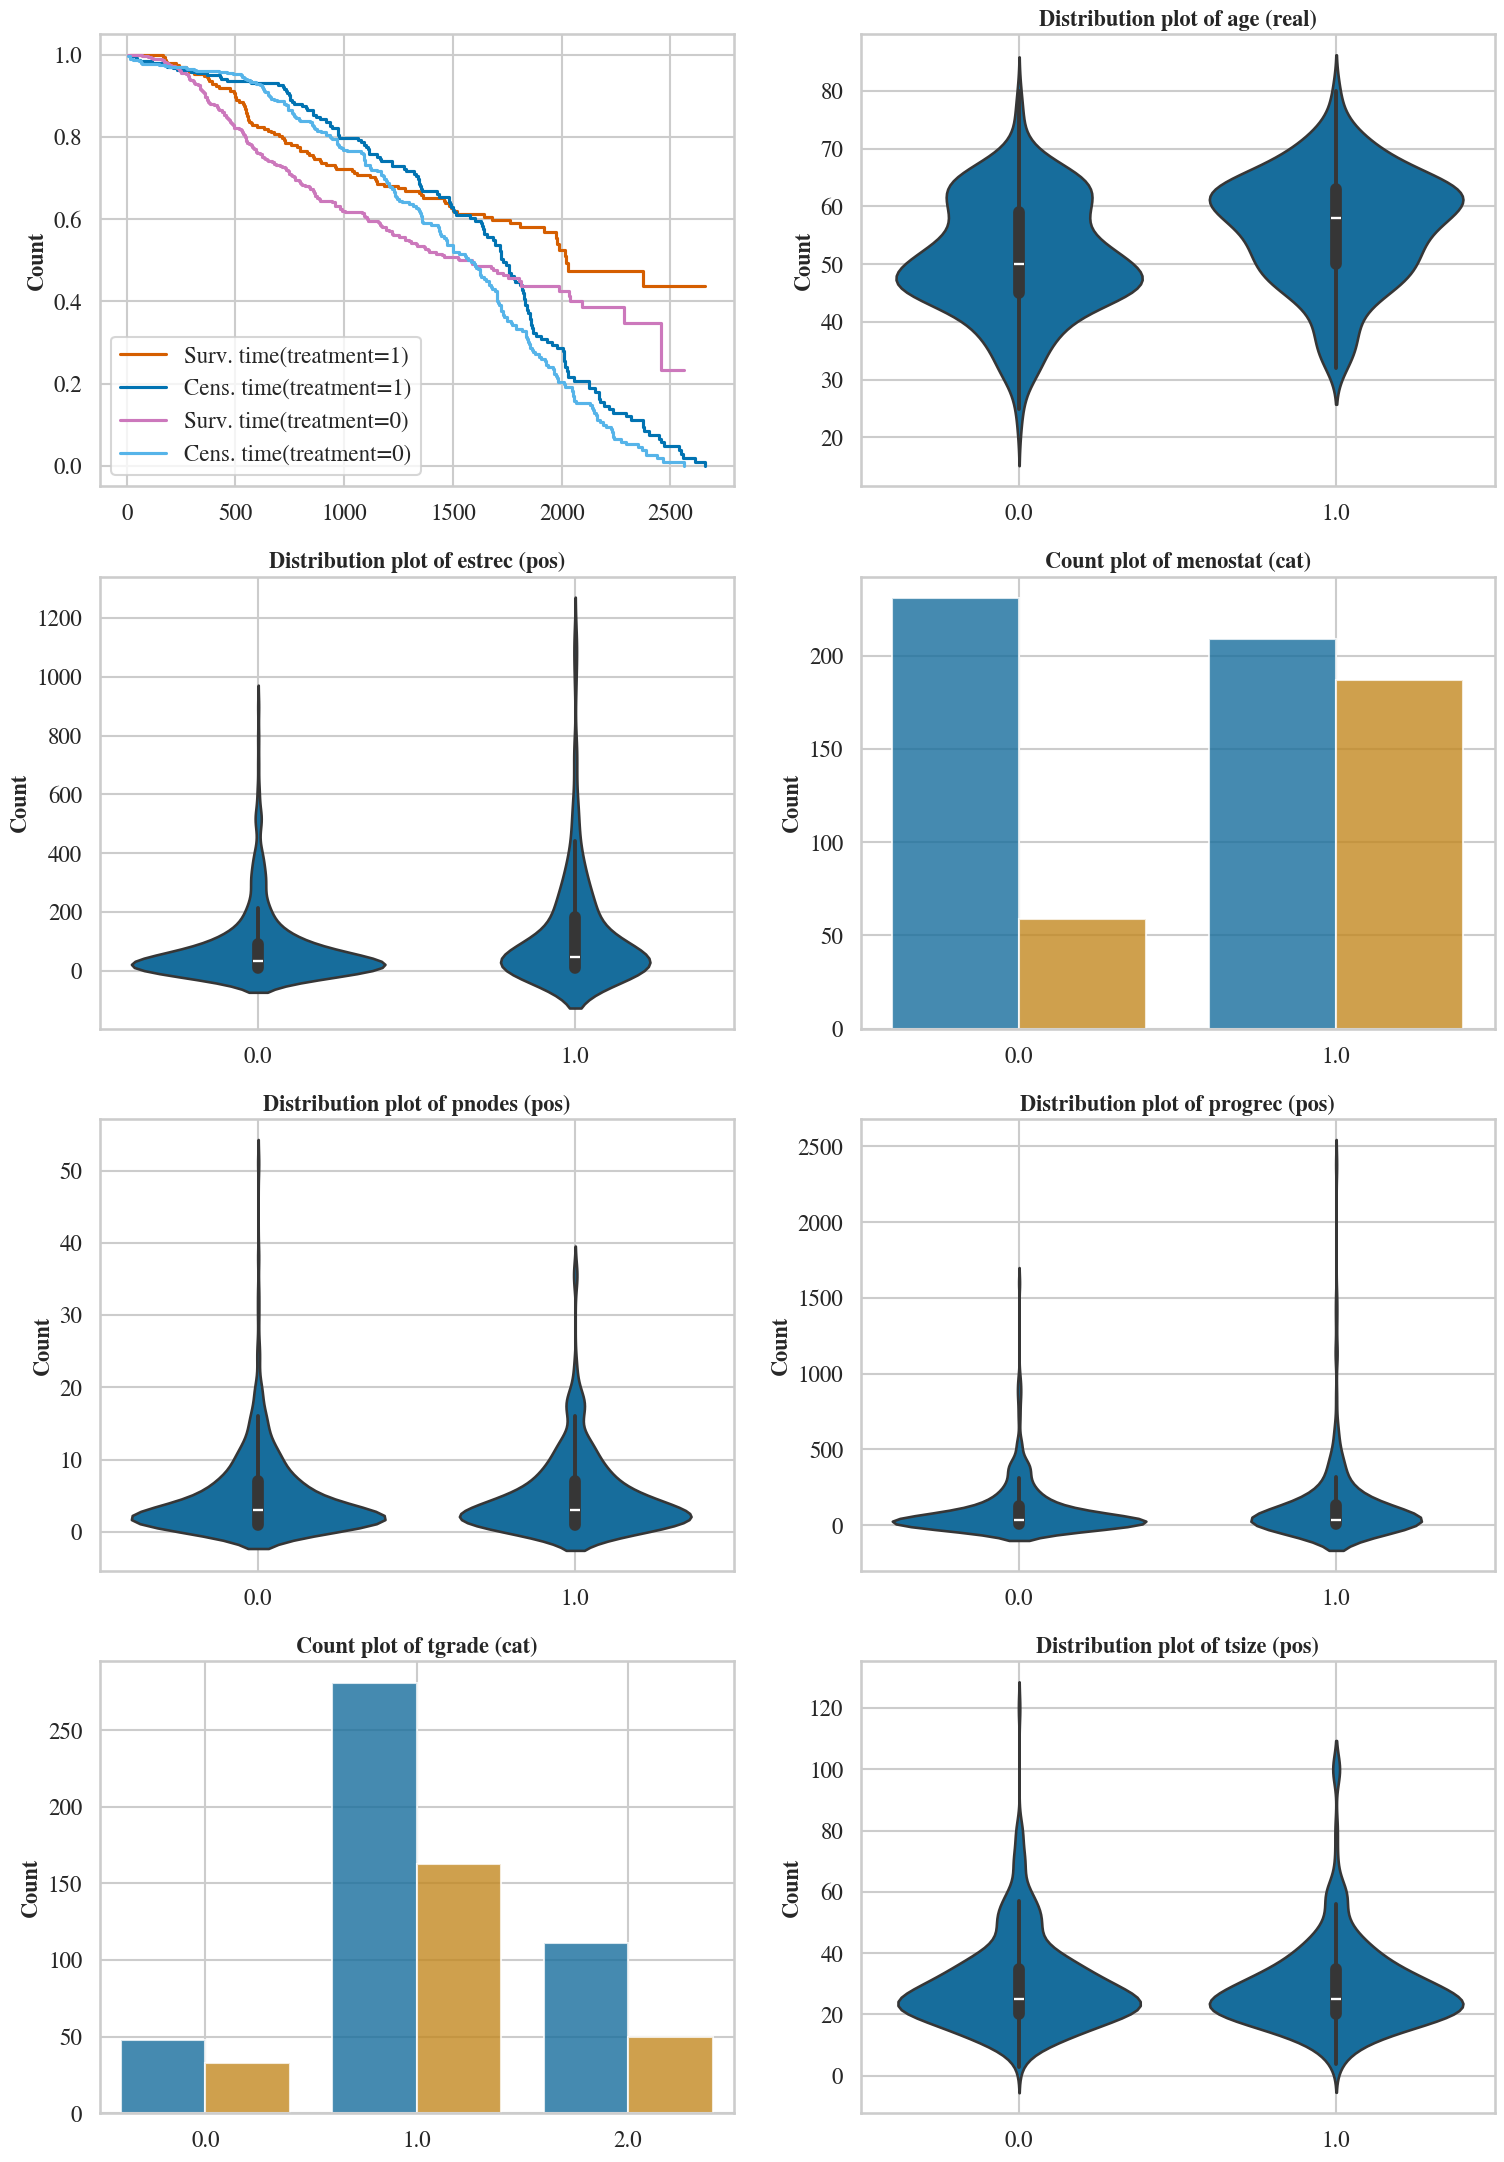

In [17]:
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_all.to_numpy(),feat_types_dict_all,feat_comparison_name = 'treatment')

In [18]:
categorical = ['censor','menostat', 'tgrade','treatment']
continuous = ['time', 'estrec', 'pnodes','progrec', 'tsize', 'age']
nonnormal = ['time', 'estrec', 'pnodes','progrec', 'tsize', 'age']

In [19]:
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                            Grouped by treatment                                                                            
                                         Missing                Overall                     0                      1 P-Value
n                                                                   686                   440                    246        
time, median [Q1,Q3]                           0  1084.0 [567.8,1684.8]  967.0 [547.8,1573.0]  1220.5 [695.8,1818.0]   0.001
censor, n (%)           0.0                                  387 (56.4)            235 (53.4)             152 (61.8)   0.041
                        1.0                                  299 (43.6)            205 (46.6)              94 (38.2)        
age, median [Q1,Q3]                            0       53.0 [46.0,61.0]      50.0 [45.0,59.0]       58.0 [50.0,63.0]  <0.001
estrec, median [Q1,Q3]                         0       36.0 [8.0,114.0]       32.0 [8.0,92.2]       46.0 [9.0,182.5]   0.009


## Training VAE

### Experiment setting

In [20]:
# Train-test split on control
data = data_control
miss_mask = miss_mask_control
true_miss_mask = true_miss_mask_control
feat_types_file = feat_types_file_control
train_test_share = .9
n_samples = data.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

data_train = data[train_index]
miss_mask_train = miss_mask[train_index]
true_miss_mask_train = true_miss_mask[train_index]

data_test = data[test_index]
miss_mask_test = miss_mask[test_index]
true_miss_mask_test = true_miss_mask[test_index]

# Adjust batch size if larger than dataset
batch_size = 100
batch_size = min(batch_size, n_train_samples)

# Number of batches
n_train_samples = data_train.shape[0]
n_batches_train = int(np.floor(n_train_samples / batch_size))
n_train_samples = n_batches_train * batch_size

# Compute real missing mask
miss_mask_train = torch.multiply(miss_mask_train, true_miss_mask_train)

# On test/val
n_test_samples = data_test.shape[0]
# Adjust batch size if larger than dataset
batch_test_size = n_test_samples
# Number of batches
n_batches_test = int(np.floor(n_test_samples / batch_test_size))

# Compute real missing mask
miss_mask_test = torch.multiply(miss_mask_test, true_miss_mask_test)
n_generated_sample = 10

### Model loading

In [21]:
import importlib
import os 

# model_name="HIVAE_factorized"
model_name="HIVAE_inputDropout"
dim_latent_z = 20
dim_latent_y = 15
dim_latent_s = 20
epochs = 1000
lr = 1e-3
save_file= "{}_{}_missing_{}_{}_z{}_y{}_s{}_batch_{}".format(model_name, dataset_name, m_perc, mask, dim_latent_z, dim_latent_y, dim_latent_s, batch_size)
# Create directories for saving models
save_dir = f'./saved_networks/{save_file}/'
os.makedirs(save_dir, exist_ok=True)
network_file = os.path.join(save_dir, f'{save_file}.pth')

# Create PyTorch HVAE model
model_loading = getattr(importlib.import_module("src"), model_name)
vae_model = model_loading(input_dim=data_train.shape[1], 
                          z_dim=dim_latent_z, 
                          y_dim=dim_latent_y, 
                          s_dim=dim_latent_s, 
                          y_dim_partition=None, 
                          feat_types_file=feat_types_file)

optimizer = optim.Adam(vae_model.parameters(), lr=lr)

### Train model

In [22]:
feat_types_dict

[{'name': 'survcens', 'type': 'surv_weibull', 'dim': '2', 'nclass': ''},
 {'name': 'age', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'name': 'estrec', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'menostat', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'pnodes', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'progrec', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'tgrade', 'type': 'cat', 'dim': '1', 'nclass': '3'},
 {'name': 'tsize', 'type': 'pos', 'dim': '1', 'nclass': ''}]

Epoch: [ 0]  time: 0.2075, ELBO_train: -25.81894302, KL_z: 1.54851643, KL_s: 0.11436780, reconstruction loss: -24.15605879
Epoch: [100]  time: 3.6149, ELBO_train: -22.92322922, KL_z: 0.79847441, KL_s: 0.04209963, reconstruction loss: -22.08265517
Epoch: [200]  time: 7.3202, ELBO_train: -22.93302663, KL_z: 0.97917197, KL_s: 0.03581603, reconstruction loss: -21.91803863
Epoch: [300]  time: 10.7314, ELBO_train: -22.75545565, KL_z: 1.04245110, KL_s: 0.03795091, reconstruction loss: -21.67505364
Epoch: [400]  time: 13.8734, ELBO_train: -22.77334913, KL_z: 1.14874347, KL_s: 0.04221781, reconstruction loss: -21.58238784
Epoch: [500]  time: 17.2554, ELBO_train: -22.73950068, KL_z: 1.25049289, KL_s: 0.04591878, reconstruction loss: -21.44308901
Epoch: [600]  time: 20.3012, ELBO_train: -22.69787025, KL_z: 1.35156667, KL_s: 0.04669873, reconstruction loss: -21.29960485
Epoch: [700]  time: 23.0325, ELBO_train: -22.36893082, KL_z: 1.42372203, KL_s: 0.04871408, reconstruction loss: -20.89649471
Epoc

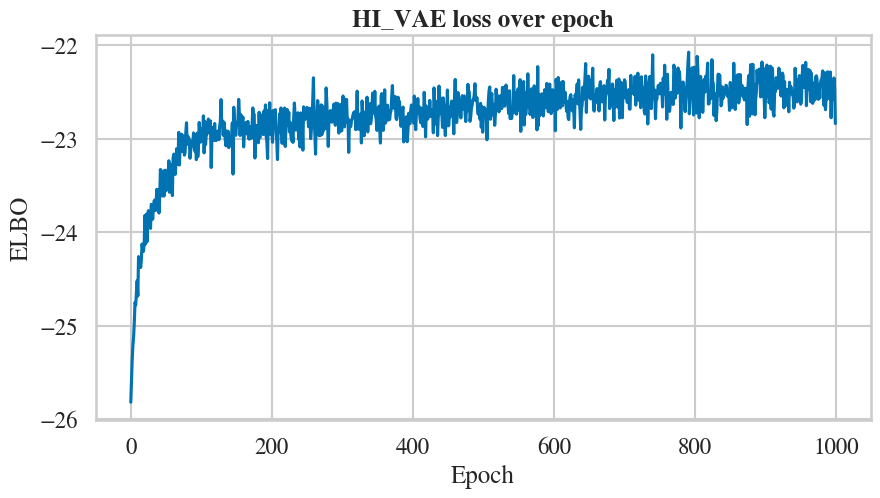

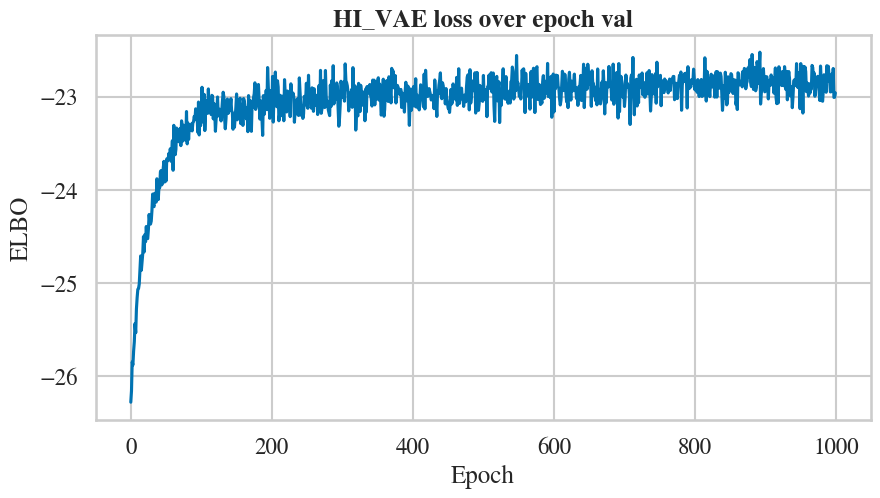

In [23]:
start_time = time.time()
loss_train, error_observed_train, error_missing_train = [], [], []
loss_val, error_observed_val, error_missing_val = [], [], []

rng = np.random.default_rng(seed=42)
for epoch in range(epochs):
    avg_loss, avg_KL_s, avg_KL_z = 0.0, 0.0, 0.0
    avg_loss_val, avg_KL_s_val, avg_KL_z_val = 0.0, 0.0, 0.0
    samples_list, p_params_list, q_params_list, log_p_x_total, log_p_x_missing_total = [], [], [], [], []
    tau = max(1.0 - 0.01 * epoch, 1e-3)

    # Shuffle training data
    perm = rng.permutation(data_train.shape[0])
    data_train = data_train[perm]
    miss_mask_train = miss_mask_train[perm]
    true_miss_mask_train = true_miss_mask_train[perm]

    for i in range(n_batches_train):
        # Get batch data
        data_list, miss_list = data_processing.next_batch(data_train, feat_types_dict, miss_mask_train, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]


        # Compute loss
        optimizer.zero_grad()
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau, n_generated_sample=1)
        vae_res["neg_ELBO_loss"].backward()
        optimizer.step()

        with torch.no_grad():

            avg_loss += vae_res["neg_ELBO_loss"].item() / n_batches_train
            avg_KL_s += torch.mean(vae_res["KL_s"]).item() / n_batches_train
            avg_KL_z += torch.mean(vae_res["KL_z"]).item() / n_batches_train
            # Number of samples generated by one input data

            

            
            for i in range(n_batches_test):
                data_list_test, miss_list_test = data_processing.next_batch(data_test, feat_types_dict, miss_mask_test, batch_test_size, i)
            
                # Mask unknown data (set unobserved values to zero)
                data_list_observed_test = [data * miss_list_test[:, i].view(batch_test_size, 1) for i, data in enumerate(data_list_test)]
            
                vae_res_test = vae_model.forward(data_list_observed_test, data_list_test, miss_list_test, tau=1e-3, n_generated_sample=1)
                avg_loss_val += vae_res_test["neg_ELBO_loss"].item() / n_batches_train
                avg_KL_s_val += torch.mean(vae_res_test["KL_s"]).item() / n_batches_train
                avg_KL_z_val += torch.mean(vae_res_test["KL_z"]).item() / n_batches_train
                #print(avg_loss_val)
            
            
     

        # Save the generated samlpes and estimated parameters !
        samples_list.append(vae_res["samples"])
        p_params_list.append(vae_res["p_params"])
        q_params_list.append(vae_res["q_params"])
        log_p_x_total.append(vae_res["log_p_x"])
        log_p_x_missing_total.append(vae_res["log_p_x_missing"])


    #Concatenate samples in arrays
    s_total, z_total, y_total, est_data_train = statistic.samples_concatenation(samples_list)
    
    # Transform discrete variables back to the original values
    data_train_transformed = data_processing.discrete_variables_transformation(data_train[: n_train_samples], feat_types_dict)
    est_data_train_transformed = data_processing.discrete_variables_transformation(est_data_train[0], feat_types_dict)
    # est_data_train_mean_imputed = statistic.mean_imputation(data_train_transformed, miss_mask_train[: n_train_samples], feat_types_dict)

    # Compute errors
    error_observed_samples, error_missing_samples = statistic.error_computation(data_train_transformed, est_data_train_transformed, 
                                                                                feat_types_dict, miss_mask[:n_train_samples])
    
    # # #Create global dictionary of the distribution parameters
    q_params_complete = statistic.q_distribution_params_concatenation(q_params_list)
    
    #Number of clusters created
    cluster_index = torch.argmax(q_params_complete['s'], 1)
    cluster = torch.unique(cluster_index)
    #print('Clusters: ' + str(len(cluster)))

    # Save average loss and error
    loss_train.append(avg_loss)
    loss_val.append(avg_loss_val)
    error_observed_train.append(torch.mean(error_observed_samples))
    error_missing_train.append(torch.mean(error_missing_samples))
    if epoch % 100 == 0:
        visualization.print_loss(epoch, start_time, -avg_loss, avg_KL_s, avg_KL_z)

print("Training finished.")

torch.save(vae_model.state_dict(), network_file)

visualization.plot_loss_evolution(-np.array(loss_train), title = "HI_VAE loss over epoch",
                                xlabel = "Epoch", ylabel = "ELBO")
visualization.plot_loss_evolution(-np.array(loss_val), title = "HI_VAE loss over epoch val",
                                xlabel = "Epoch", ylabel = "ELBO")


## Generated samples from control dataset

In [24]:
data.shape

torch.Size([440, 12])

In [25]:
data_forgen = data#[train_index]
miss_mask_forgen = miss_mask#[train_index]
true_miss_mask_forgen = true_miss_mask#[train_index]

In [26]:
miss_mask_forgen.shape

torch.Size([440, 8])

In [27]:
data_forgen.shape

torch.Size([440, 12])

#### Generate from original sample

In [28]:
n_samples_forgen = data_forgen.shape[0]
batch_size = n_samples_forgen
print(n_samples_forgen)
# Number of batches
n_batches_generation = 1

# Compute real missing mask
miss_mask_forgen = torch.multiply(miss_mask_forgen, true_miss_mask_forgen)

# Number of samples generated by one input data
n_generated_sample = 100

with torch.no_grad(): 
    
    error_mode_global = 0.0
    avg_loss = 0.0
    samples_list = []
    
    for i in range(n_batches_generation):
        data_list, miss_list = data_processing.next_batch(data_forgen, feat_types_dict, miss_mask_forgen, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]
        
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau=1e-3, n_generated_sample=n_generated_sample)
        samples_list.append(vae_res["samples"])
    
    
    #Concatenate samples in arrays
    est_data_gen = statistic.samples_concatenation(samples_list)[-1]
    est_data_gen_transformed = []
    for j in range(n_generated_sample):
        data_trans = data_processing.discrete_variables_transformation(est_data_gen[j], feat_types_dict)
        data_trans = data_processing.survival_variables_transformation(data_trans,feat_types_dict)
        est_data_gen_transformed.append(data_trans.unsqueeze(0))
        
    est_data_gen_transformed = torch.cat(est_data_gen_transformed, dim=0)

440


### Statistical analysis with simulated vs initial control data

In [29]:
df_transformed_initial = pd.DataFrame(data_transformed_control.numpy(), columns=gbsb2_control_columns)
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[3].numpy(), columns=gbsb2_control_columns)
df_transformed_initial["sample"]=1
df_transformed_generated["sample"]=0
df_transformed_initial_generated = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)

In [30]:
df_transformed_generated

,time,censor,age,estrec,menostat,pnodes,progrec,tgrade,tsize,sample
0,1666.513184,0.0,55.111374,14.093041,1.0,3.691854,6.601092,1.0,26.184071,0
1,911.053528,1.0,56.908321,0.737536,1.0,5.166953,110.341217,1.0,45.921040,0
2,175.121307,1.0,58.054440,0.283767,0.0,10.976030,12.906230,1.0,71.053116,0
3,2415.149170,0.0,63.753525,44.840630,1.0,1.517357,8.956190,1.0,12.917516,0
4,121.977760,1.0,60.691086,4.488075,1.0,9.988558,6.024552,2.0,37.115341,0
...,...,...,...,...,...,...,...,...,...,...
435,839.430420,0.0,45.634468,103.675354,0.0,1.763063,111.491325,1.0,21.387587,0
436,716.027649,1.0,45.680138,0.959511,1.0,3.471745,10.844721,2.0,28.056341,0
437,1558.951660,0.0,56.575954,27.330288,0.0,1.478462,3.013236,0.0,18.825991,0
438,1251.888184,0.0,47.031811,39.821796,1.0,5.543298,1503.513306,1.0,48.132984,0


comparison variable sample 9


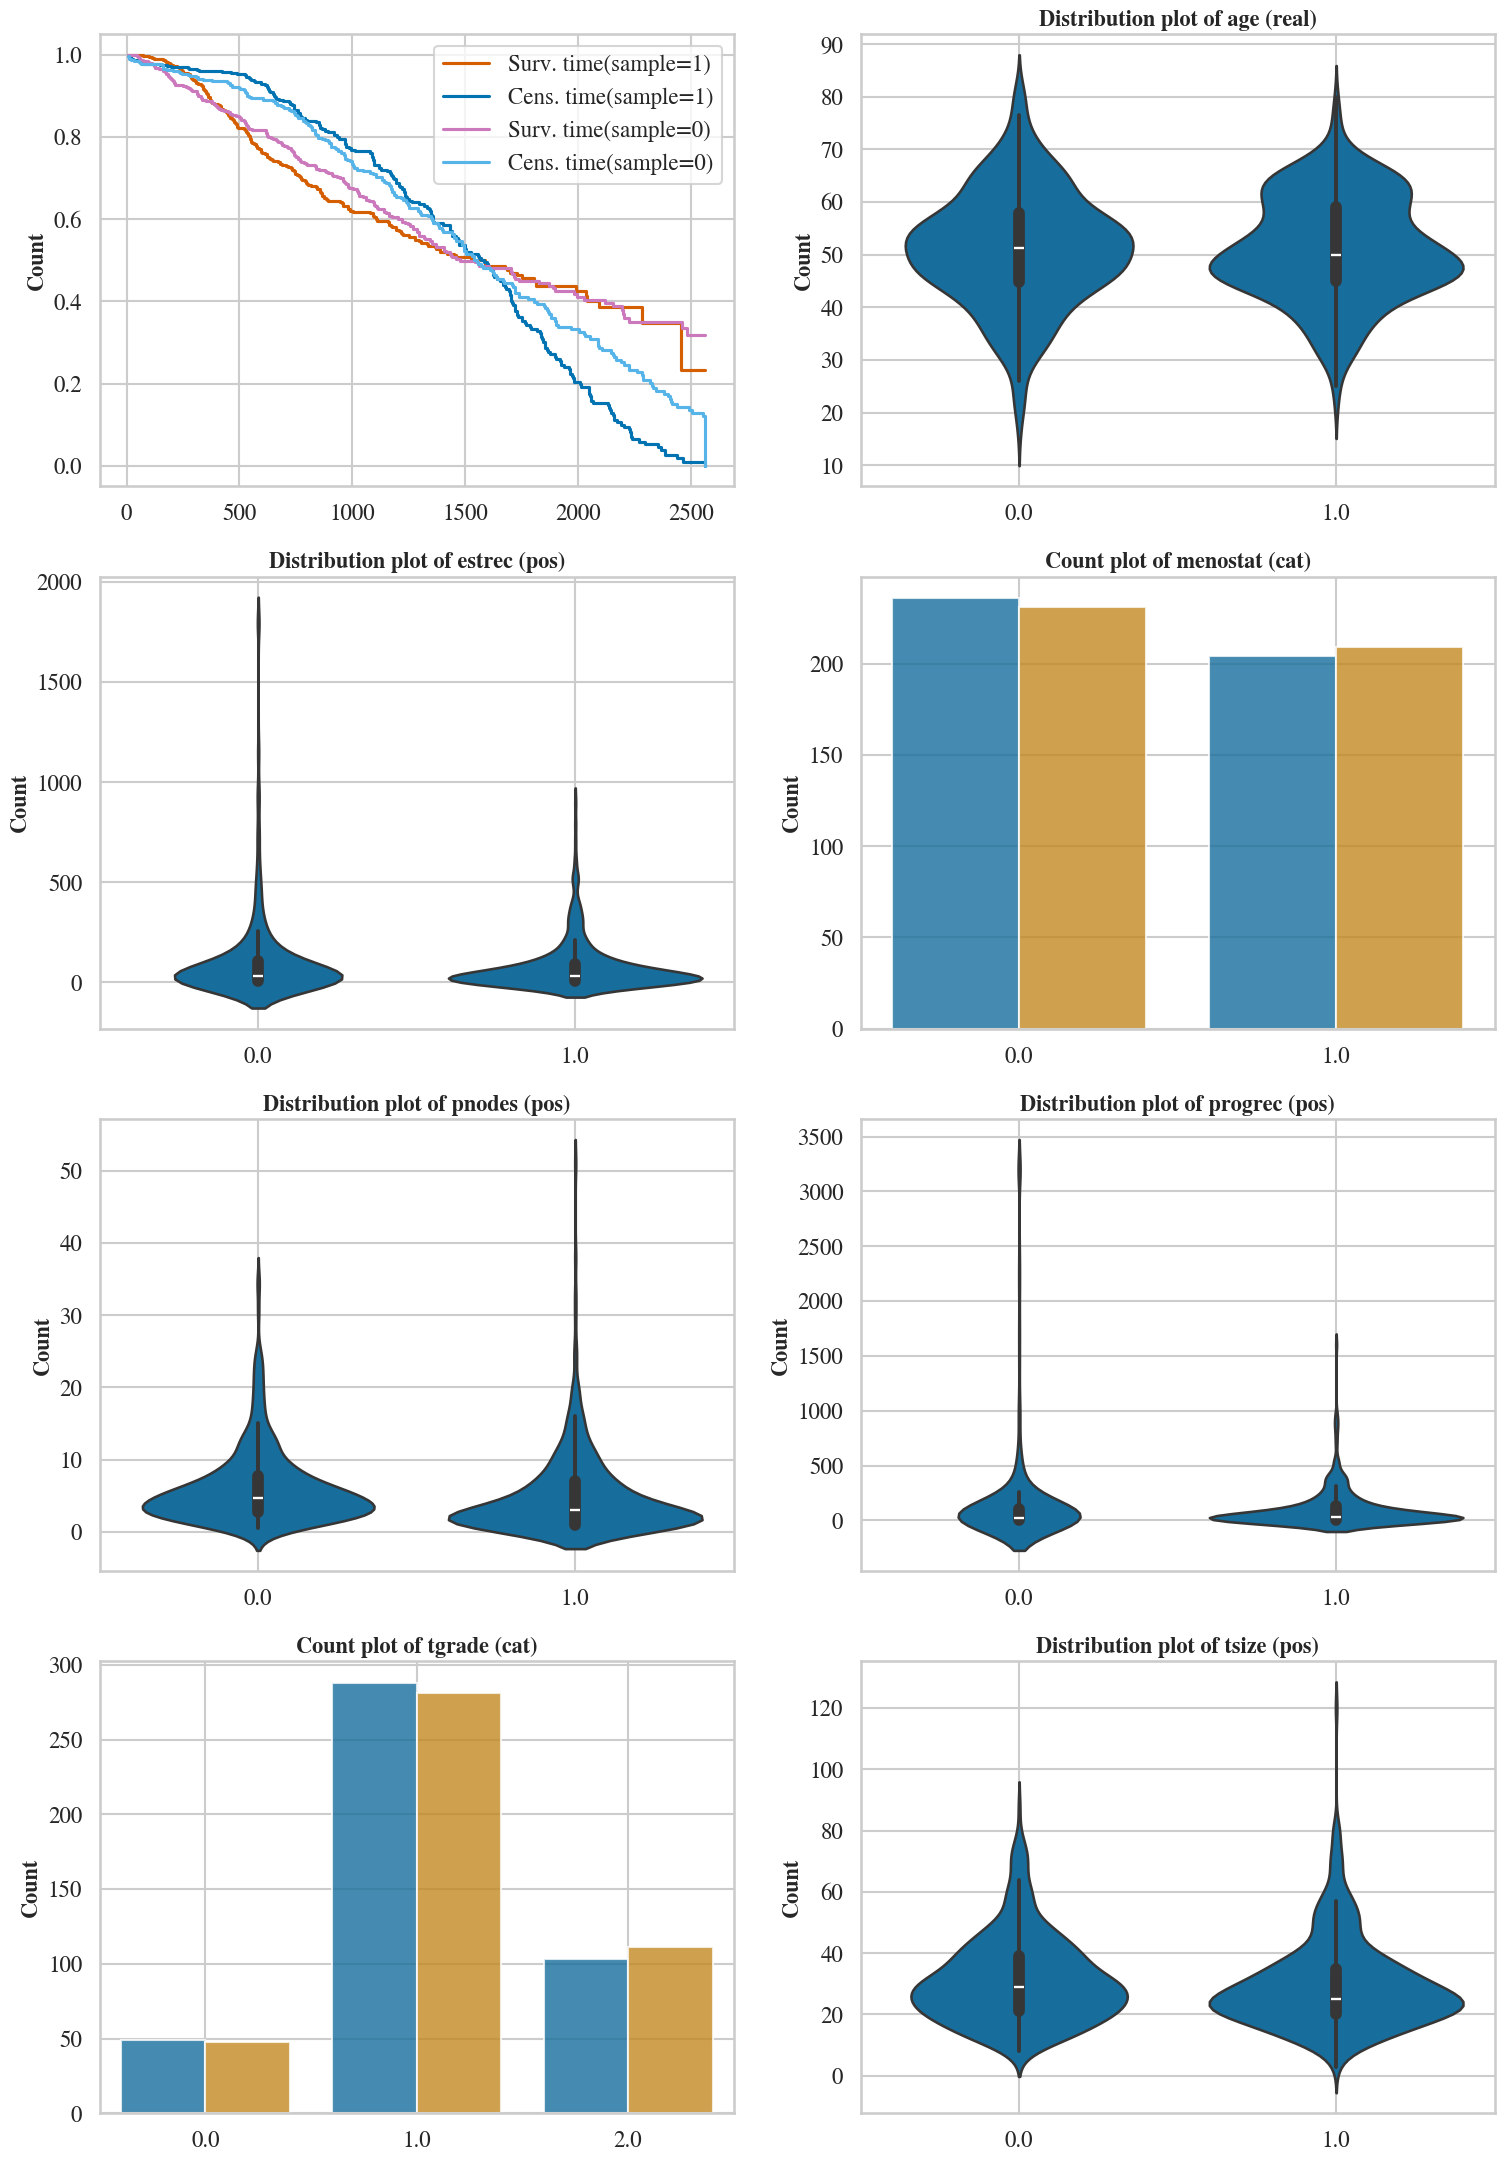

In [31]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_initial_generated.to_numpy(),feat_types_dict_all,feat_comparison_name = 'sample')

In [32]:
categorical = ['censor','menostat', 'tgrade','sample']
continuous = ['time', 'estrec', 'pnodes','progrec', 'tsize', 'age']
nonnormal = ['time', 'estrec', 'progrec', 'pnodes','tsize', 'age'] ## Doit-on mettre pnodes en nonnormal ?

In [33]:
table1 = TableOne(df_transformed_initial_generated, categorical=categorical, continuous=continuous, groupby='sample',nonnormal=nonnormal, pval=True)
print(table1)

                            Grouped by sample                                                                          
                                      Missing               Overall                     0                     1 P-Value
n                                                               880                   440                   440        
time, median [Q1,Q3]                        0  977.9 [541.1,1557.3]  994.6 [532.9,1541.6]  967.0 [547.8,1573.0]   0.696
censor, n (%)           0.0                              472 (53.6)            237 (53.9)            235 (53.4)   0.946
                        1.0                              408 (46.4)            203 (46.1)            205 (46.6)        
age, median [Q1,Q3]                         0      51.0 [45.0,58.5]      51.3 [44.8,57.8]      50.0 [45.0,59.0]   0.669
estrec, median [Q1,Q3]                      0      32.0 [7.1,102.8]      31.9 [7.0,108.6]       32.0 [8.0,92.2]   0.346
menostat, n (%)         0.0             

### Statistical analysis: generated control x initial treated

In [34]:
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[2].numpy(), columns=gbsb2_control_columns)
df_transformed_generated['treatment'] = 0
df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
#df_transformed_T_Cgen = df_transformed_T_Cgen.drop('sample',axis=1)
#df_transformed_T_Cgen.head()

In [35]:
categorical = ['censor','menostat', 'tgrade','treatment']
continuous = ['time', 'estrec', 'pnodes','progrec', 'tsize', 'age']
nonnormal = ['time', 'estrec', 'progrec', 'pnodes','tsize', 'age'] ## Doit-on mettre pnodes en nonnormal ?
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                            Grouped by treatment                                                                            
                                         Missing                Overall                     0                      1 P-Value
n                                                                   686                   440                    246        
time, median [Q1,Q3]                           0  1084.0 [567.8,1684.8]  967.0 [547.8,1573.0]  1220.5 [695.8,1818.0]   0.001
censor, n (%)           0.0                                  387 (56.4)            235 (53.4)             152 (61.8)   0.041
                        1.0                                  299 (43.6)            205 (46.6)              94 (38.2)        
age, median [Q1,Q3]                            0       53.0 [46.0,61.0]      50.0 [45.0,59.0]       58.0 [50.0,63.0]  <0.001
estrec, median [Q1,Q3]                         0       36.0 [8.0,114.0]       32.0 [8.0,92.2]       46.0 [9.0,182.5]   0.009


In [36]:
table1 = TableOne(df_transformed_T_Cgen, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                            Grouped by treatment                                                                            
                                         Missing                Overall                     0                      1 P-Value
n                                                                   686                   440                    246        
time, median [Q1,Q3]                           0  1060.9 [540.4,1693.6]  968.9 [468.6,1614.6]  1220.5 [695.8,1818.0]  <0.001
censor, n (%)           0.0                                  400 (58.3)            248 (56.4)             152 (61.8)   0.193
                        1.0                                  286 (41.7)            192 (43.6)              94 (38.2)        
age, median [Q1,Q3]                            0       53.3 [46.0,61.0]      51.6 [43.8,58.9]       58.0 [50.0,63.0]  <0.001
estrec, median [Q1,Q3]                         0       32.0 [7.7,110.7]       27.1 [6.9,80.2]       46.0 [9.0,182.5]   0.015


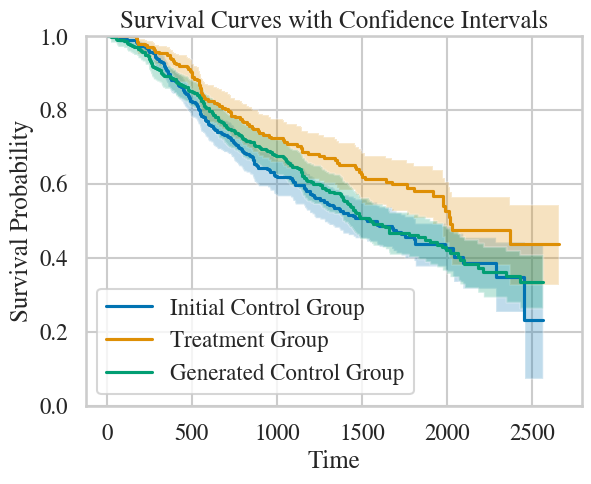

In [37]:

time_initial_C, survival_prob_initial_C, conf_int_initial_C = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_initial_T, survival_prob_initial_T, conf_int_initial_T = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_C, survival_prob_T_Cgen_C, conf_int_T_Cgen_C = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_T, survival_prob_T_Cgen_T, conf_int_T_Cgen_T = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)


plt.step(time_initial_C, survival_prob_initial_C, where="post", label="Initial Control Group")
plt.fill_between(time_initial_C, conf_int_initial_C[0], conf_int_initial_C[1], alpha=0.25, step="post")

plt.step(time_initial_T, survival_prob_initial_T, where="post", label="Treatment Group")
plt.fill_between(time_initial_T, conf_int_initial_T[0], conf_int_initial_T[1], alpha=0.25, step="post")


plt.step(time_T_Cgen_C, survival_prob_T_Cgen_C, where="post", label="Generated Control Group")
plt.fill_between(time_T_Cgen_C, conf_int_T_Cgen_C[0], conf_int_T_Cgen_C[1], alpha=0.25, step="post")


#plt.step(time_T_Cgen_T, survival_prob_T_Cgen_T, where="post")
#plt.fill_between(time_T_Cgen_T, conf_int_T_Cgen_T[0], conf_int_T_Cgen_T[1], alpha=0.25, step="post")

plt.ylim(0, 1)

# Add legend
plt.legend()

# Optional: add axis labels and title
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")

# Show the plot
plt.show()

## Tests

In [38]:
categorical_encode = ['censor','menostat', 'tgrade','treatment']

In [39]:
df_transformed_all

,time,censor,age,estrec,menostat,pnodes,progrec,tgrade,tsize,treatment
0,1814.0,1.0,70.0,66.0,1.0,3.0,48.0,1.0,21.0,0
1,772.0,1.0,73.0,65.0,1.0,1.0,26.0,1.0,35.0,0
2,448.0,1.0,32.0,13.0,0.0,24.0,0.0,2.0,57.0,0
3,2161.0,0.0,65.0,25.0,1.0,1.0,192.0,1.0,16.0,0
4,471.0,1.0,80.0,59.0,1.0,30.0,0.0,1.0,39.0,0
...,...,...,...,...,...,...,...,...,...,...
681,1219.0,0.0,56.0,174.0,1.0,2.0,53.0,1.0,32.0,1
682,662.0,1.0,56.0,700.0,1.0,5.0,113.0,0.0,42.0,1
683,974.0,0.0,61.0,346.0,1.0,5.0,141.0,1.0,27.0,1
684,504.0,1.0,60.0,11.0,1.0,6.0,8.0,1.0,40.0,1


In [41]:
df_transformed_all_oh = df_transformed_all.copy()
for feat in categorical_encode:
    df_transformed_all_oh = data_processing.encode_and_bind(df_transformed_all_oh,feat)
X_initial = df_transformed_all_oh.to_numpy()[:,2:15]
Y_initial = Surv.from_arrays(df_transformed_all_oh.to_numpy()[:,1]==1,df_transformed_all_oh.to_numpy()[:,0])    

In [48]:
number_column_treatment = 8 # in X_initial

In [49]:
cox_initial = CoxPHSurvivalAnalysis()
cox_initial.fit(X_initial,Y_initial)
cox_initial.coef_

array([-9.45340713e-03,  1.97817754e-04,  2.58156545e-01,  4.87818043e-02,
       -2.21749417e-03,  7.79832903e-03, -3.46241621e-01,  6.35978663e-01,
        7.79350191e-01])

In [51]:
coef_treat = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
for i in np.arange(n_generated_sample):
    #print(i)
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=gbsb2_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = data_processing.encode_and_bind(df_transformed_T_Cgen_oh,feat)
    
    X_T_Cgen = df_transformed_T_Cgen_oh.to_numpy()[:,2:15]
    Y_T_Cgen = Surv.from_arrays(df_transformed_T_Cgen_oh.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh.to_numpy()[:,0])
    coef_treat[i,0] = -np.log(compare_survival(Y_T_Cgen,X_T_Cgen[:,number_column_treatment])[1])
    cox_generated = CoxPHSurvivalAnalysis()
    cox_generated.fit(X_T_Cgen,Y_T_Cgen)
    coef_treat[i,1:] = cox_generated.coef_[:]


In [52]:
df_transformed_all_oh.columns

Index(['time', 'censor', 'age', 'estrec', 'menostat', 'pnodes', 'progrec',
       'tsize', 'treatment', 'tgrade1.0', 'tgrade2.0'],
      dtype='object')

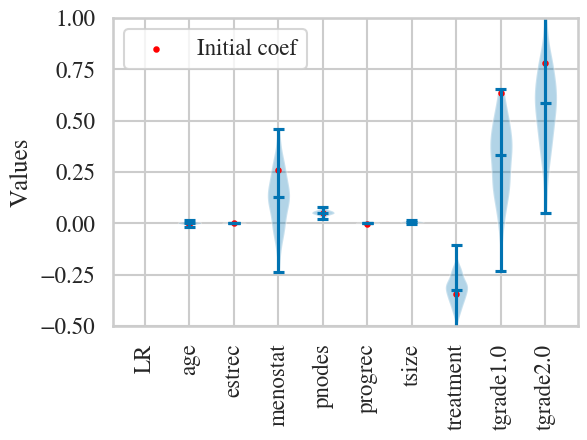

In [56]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat.shape[1])  # X-axis positions of violins
y_values = np.zeros(coef_treat.shape[1])
y_values[0] = -np.log(compare_survival(Y_initial,X_initial[:,number_column_treatment])[1])
y_values[1:] = cox_initial.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(['LR','age', 'estrec', 'menostat', 'pnodes', 'progrec', 'tsize', 'treatment', 'tgrade1.0', 'tgrade2.0'])
ax.set_ylabel("Values")
ax.set_ylim(-0.5, 1) #to zoom on treatment values
ax.legend()

plt.show()

### Log rank test

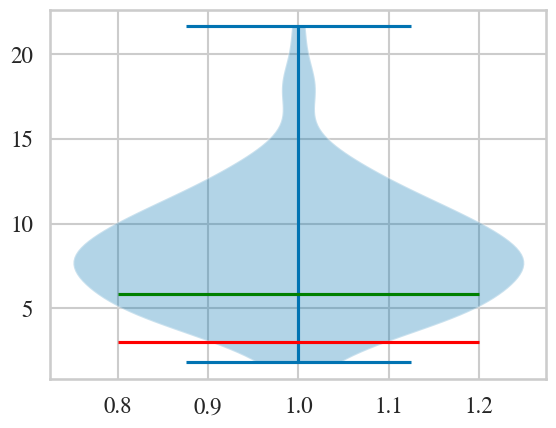

In [57]:
plt.violinplot(coef_treat[:,0])#,
plt.hlines(y_values[0],0.8,1.2,color='green')
plt.hlines(-np.log(0.05),0.8,1.2,color='red')

### Test coefficient traitement (Cox)

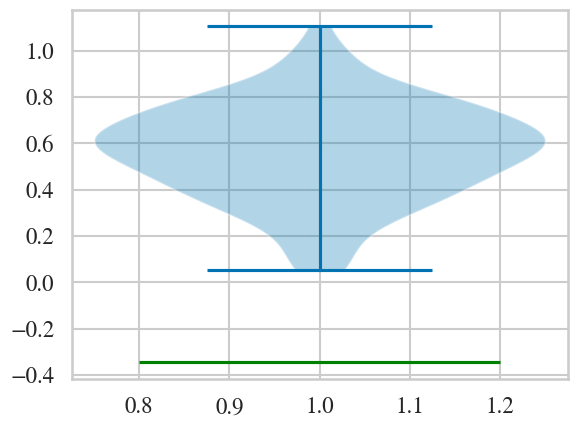

In [58]:
plt.violinplot(coef_treat[:,number_column_treatment+1])#,
plt.hlines(y_values[7],0.8,1.2,color='green')

### Statistical analysis with original data

In [52]:
gbsg2_control = pd.read_csv(data_file_control,header=None)

gbsg2_control.columns = gbsb2_control_columns
gbsg2_control.head()

,time,censor,age,estrec,menostat,pnodes,progrec,tgrade,tsize
0,1814.0,1,70.0,66.0,1,3.0,48.0,2,21.0
1,772.0,1,73.0,65.0,1,1.0,26.0,2,35.0
2,448.0,1,32.0,13.0,0,24.0,0.0,3,57.0
3,2161.0,0,65.0,25.0,1,1.0,192.0,2,16.0
4,471.0,1,80.0,59.0,1,30.0,0.0,2,39.0


In [53]:
np.quantile(gbsg2_control[gbsg2_control['censor']==1]['time'],0.95)

1724.1999999999996

### Data loading and Feature analysis treated/control

survcens
age
estrec
menostat
pnodes
progrec
tgrade
tsize


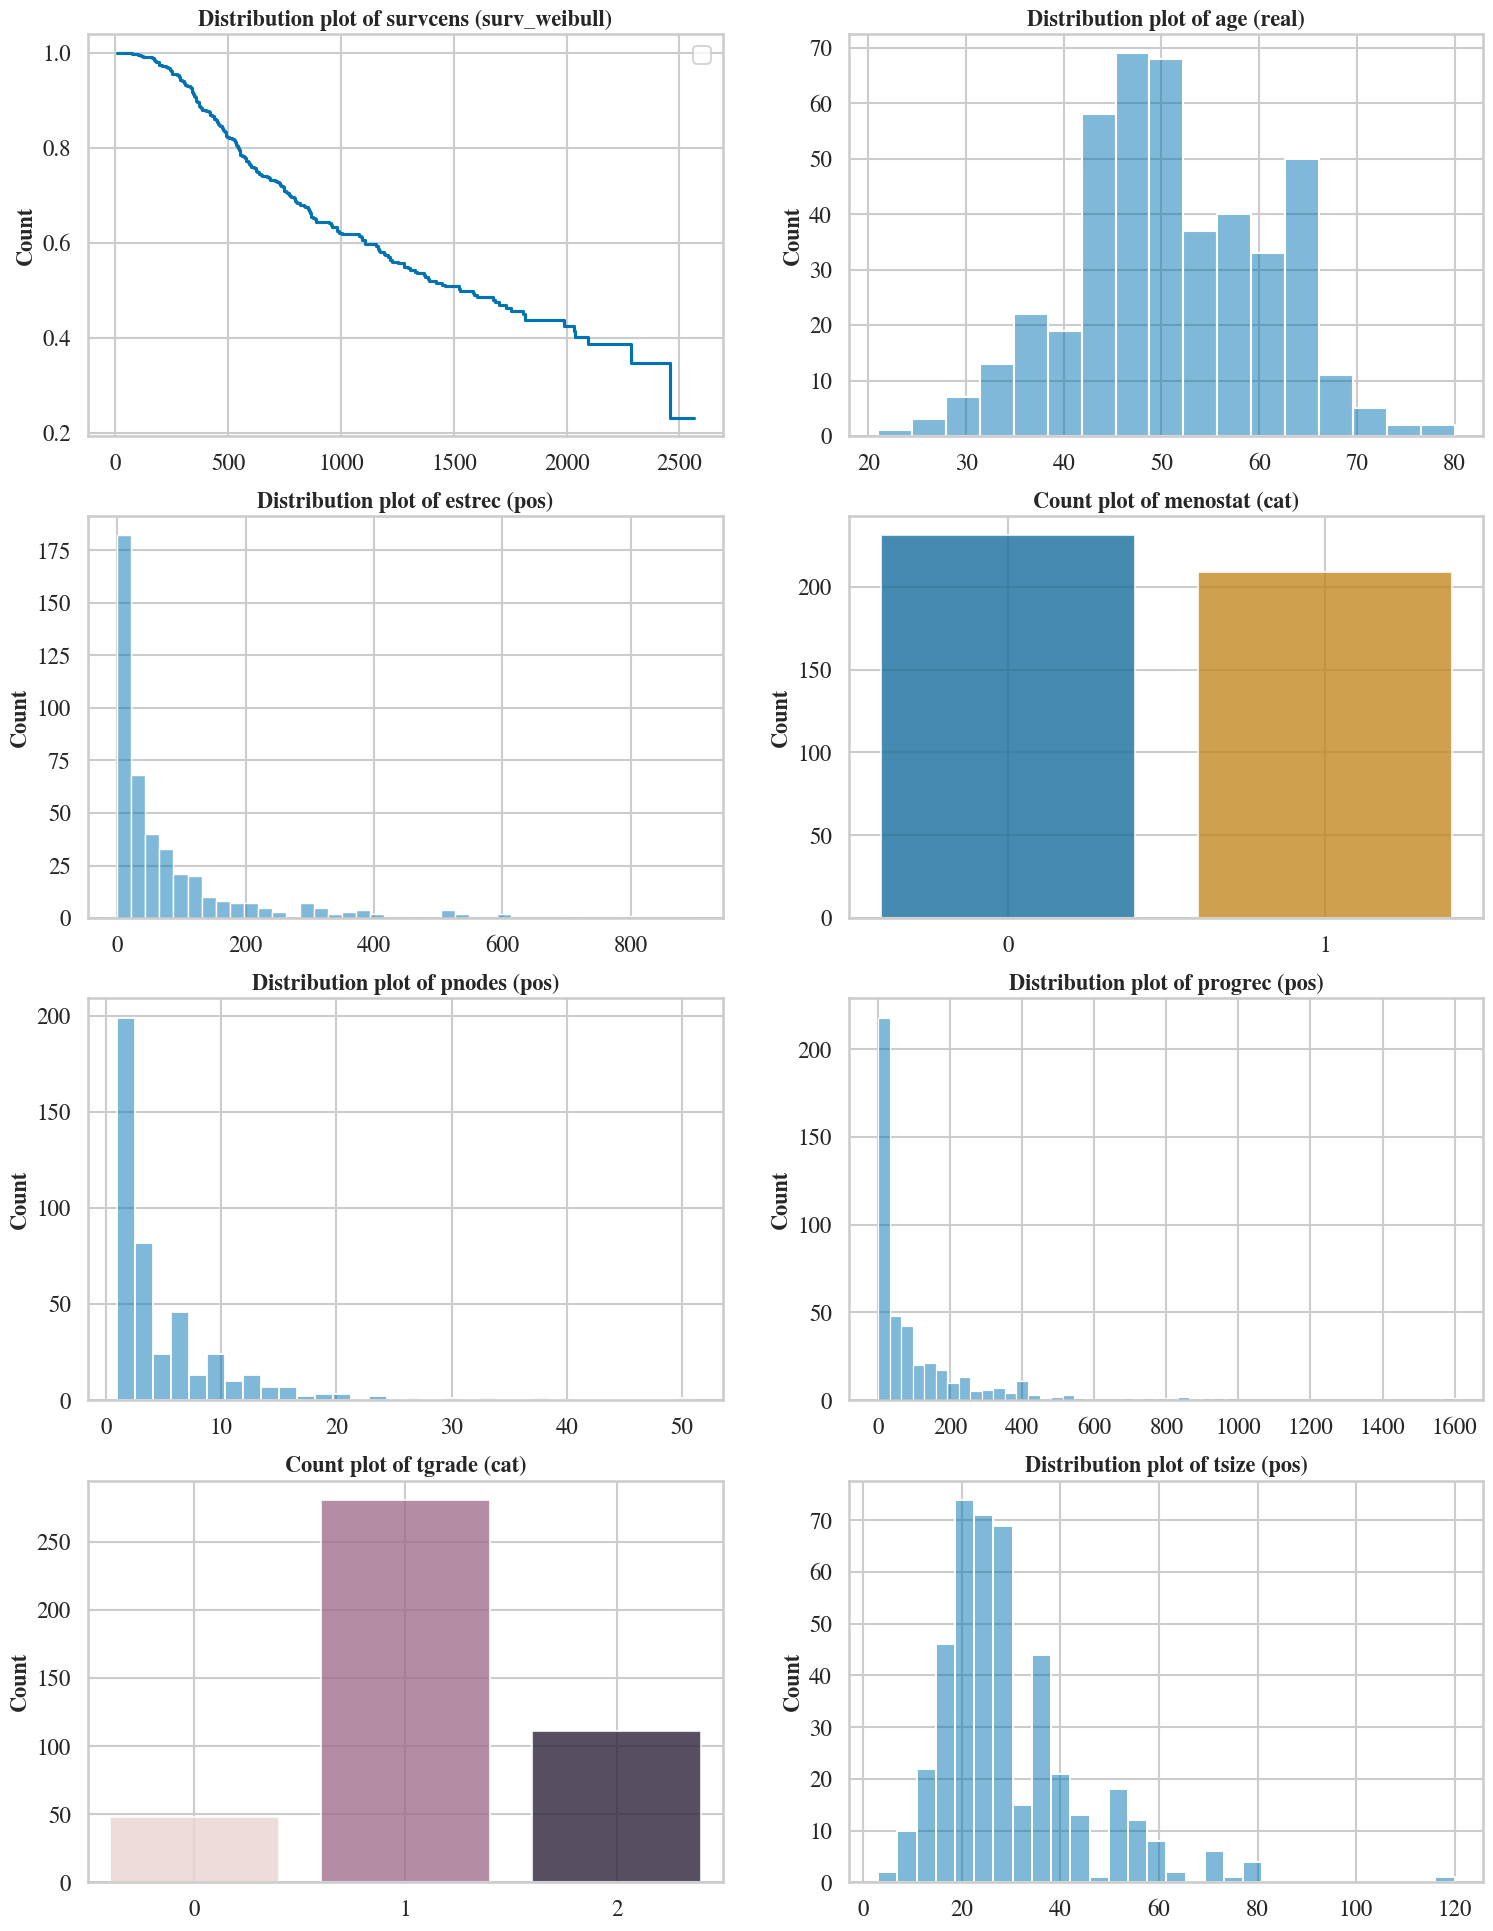

In [54]:
# Load training data
data_control, feat_types_dict, miss_mask_control, true_miss_mask_control, n_samples_control = data_processing.read_data(data_file_control, 
                                                                                                                        feat_types_file_control, 
                                                                                                                        miss_file, true_miss_file)
# Feature analysis
data_transformed_control = data_processing.discrete_variables_transformation(data_control, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

visualization.plot_data(data_transformed_control, feat_types_dict)


In [55]:
feat_types_dict[3]#['name']


{'name': 'menostat', 'type': 'cat', 'dim': '1', 'nclass': '2'}

In [56]:
gbsg2_control = pd.read_csv(data_file_control,header=None)

gbsg2_control.columns = gbsb2_control_columns
gbsg2_control.head()

,time,censor,age,estrec,menostat,pnodes,progrec,tgrade,tsize
0,1814.0,1,70.0,66.0,1,3.0,48.0,2,21.0
1,772.0,1,73.0,65.0,1,1.0,26.0,2,35.0
2,448.0,1,32.0,13.0,0,24.0,0.0,3,57.0
3,2161.0,0,65.0,25.0,1,1.0,192.0,2,16.0
4,471.0,1,80.0,59.0,1,30.0,0.0,2,39.0


survcens
age
estrec
menostat
pnodes
progrec
tgrade
tsize


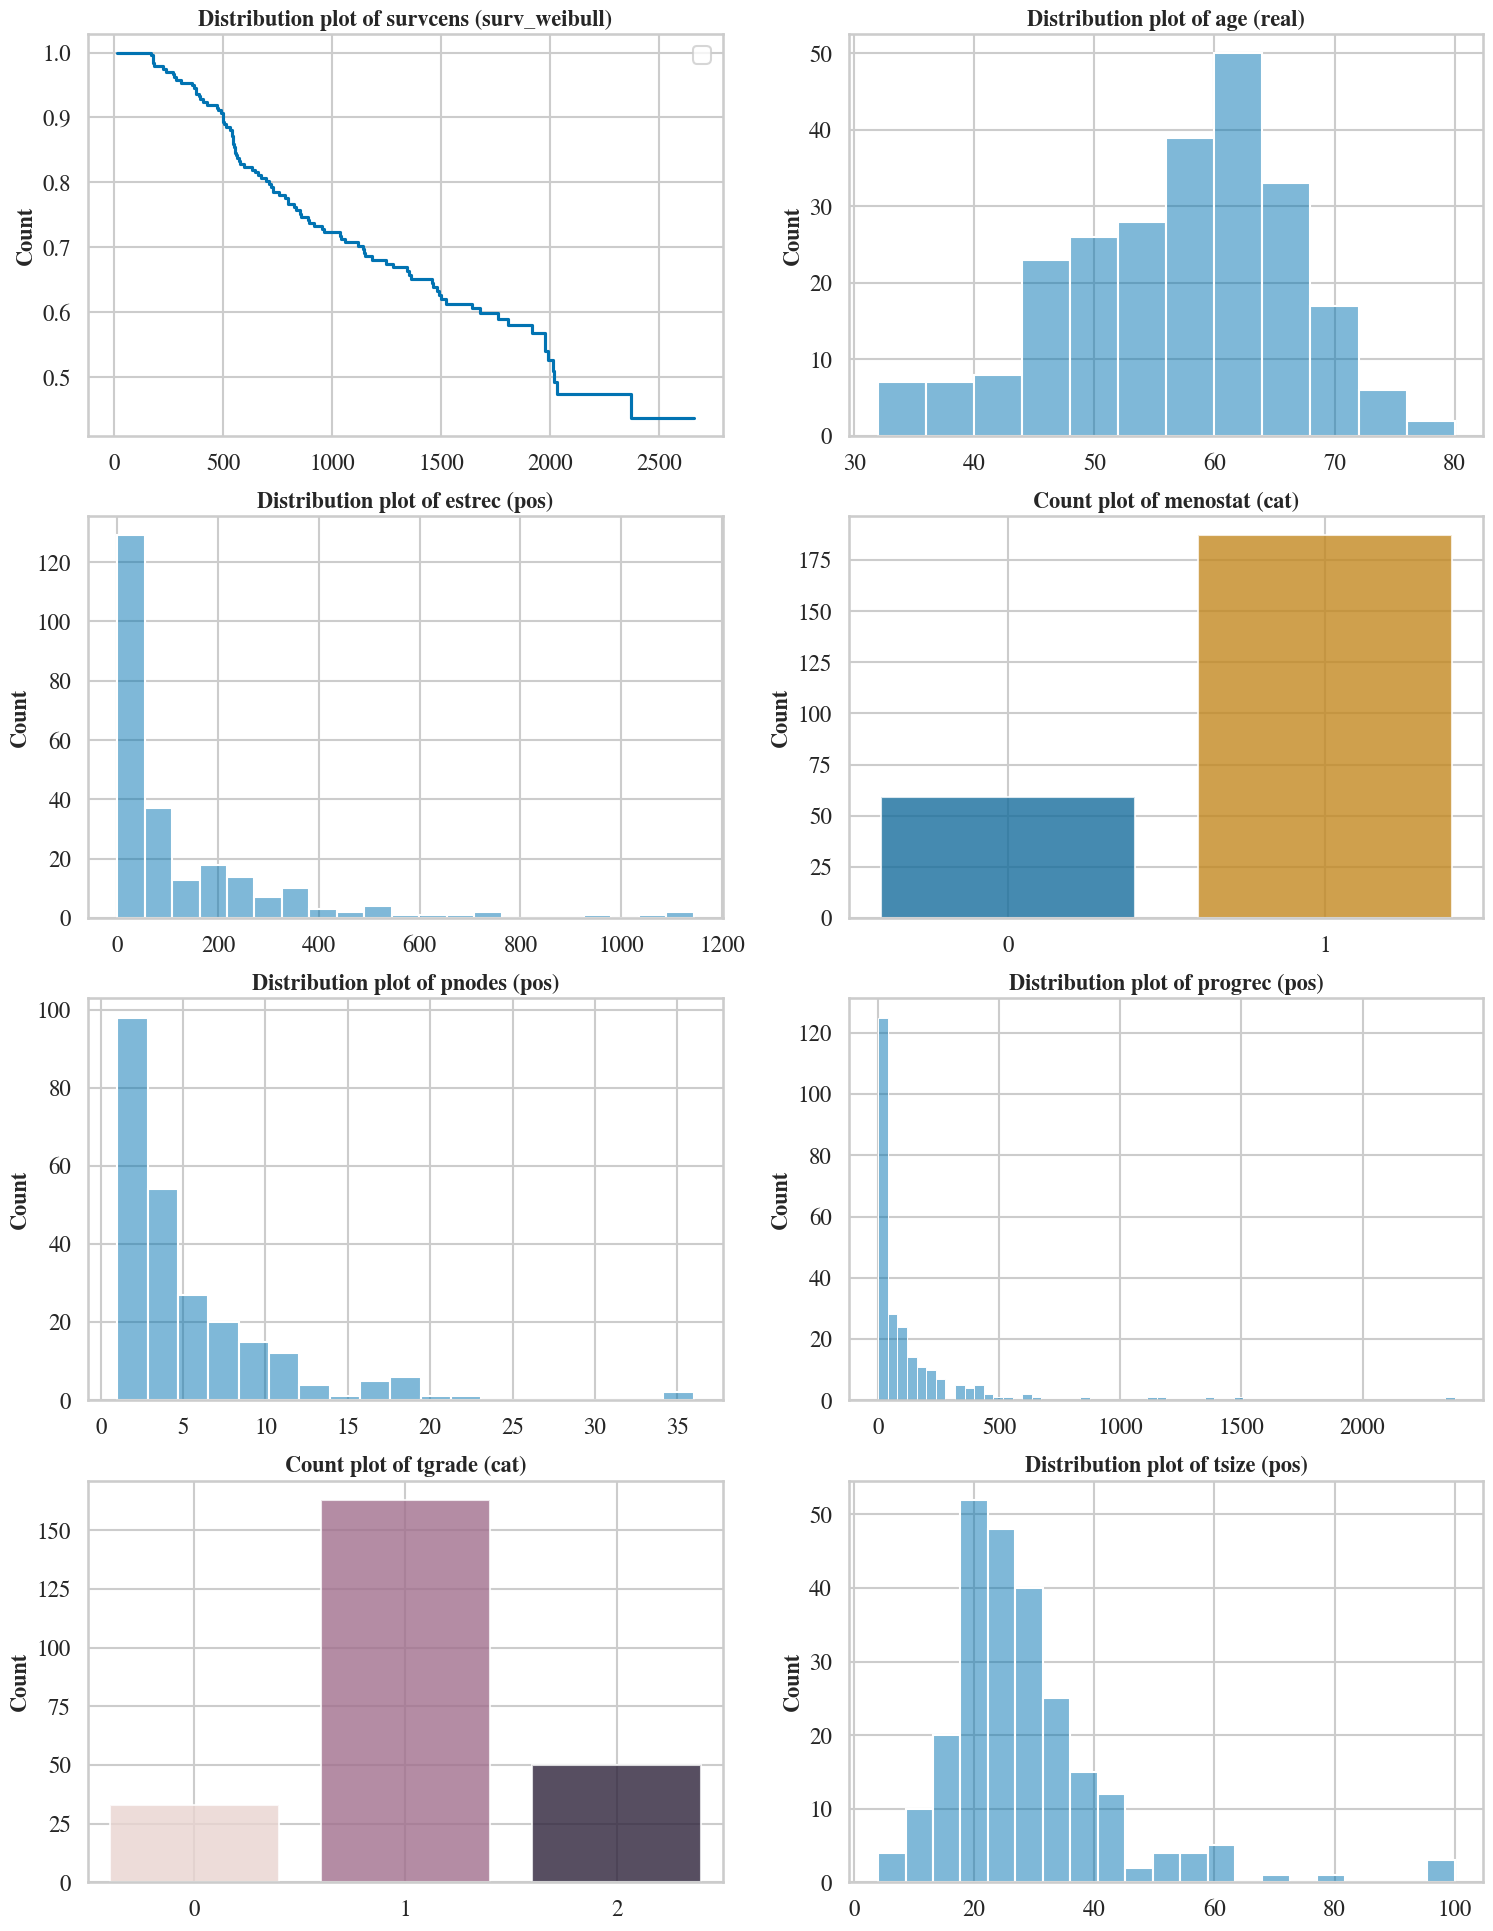

In [57]:
# Load training data
data_treated, feat_types_dict, miss_mask_treated, true_miss_mask_treated, n_samples_treated = data_processing.read_data(data_file_treated, 
                                                                                                                        feat_types_file_control, 
                                                                                                                        miss_file, true_miss_file)

# Feature analysis
data_transformed_treated = data_processing.discrete_variables_transformation(data_treated, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

visualization.plot_data(data_transformed_treated, feat_types_dict)

In [58]:
df_transformed_treated = pd.DataFrame(data_transformed_treated.numpy(), columns=gbsb2_control_columns)
df_transformed_control = pd.DataFrame(data_transformed_control.numpy(), columns=gbsb2_control_columns)
df_transformed_treated["treatment"]=1
df_transformed_control["treatment"]=0
df_transformed_all = pd.concat([df_transformed_control, df_transformed_treated], ignore_index=True)

In [59]:
df_transformed_all.columns

Index(['time', 'censor', 'age', 'estrec', 'menostat', 'pnodes', 'progrec',
       'tgrade', 'tsize', 'treatment'],
      dtype='object')

In [60]:
categorical = []
continuous = []
nonnormal = []
for index, row in pd.read_csv(feat_types_file_control).iterrows():
    if row['type'] == 'cat':
        categorical.append(row['name'])
    elif row['type'] in ['real','pos','count']:
        continuous.append(row['name'])
        if row['type'] in ['pos','count']:
            nonnormal.append(row['name'])
categorical.append('censor')
categorical.append('treatment')
continuous.append('time')
nonnormal.append('time')

In [61]:
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                            Grouped by treatment                                                                            
                                         Missing                Overall                     0                      1 P-Value
n                                                                   686                   440                    246        
time, median [Q1,Q3]                           0  1084.0 [567.8,1684.8]  967.0 [547.8,1573.0]  1220.5 [695.8,1818.0]   0.001
censor, n (%)           0.0                                  387 (56.4)            235 (53.4)             152 (61.8)   0.041
                        1.0                                  299 (43.6)            205 (46.6)              94 (38.2)        
age, mean (SD)                                 0            53.1 (10.1)           51.1 (10.0)             56.6 (9.4)  <0.001
estrec, median [Q1,Q3]                         0       36.0 [8.0,114.0]       32.0 [8.0,92.2]       46.0 [9.0,182.5]   0.009


### Experiment setting

In [62]:
# Train-test split on control
data = data_control
miss_mask = miss_mask_control
true_miss_mask = true_miss_mask_control
feat_types_file = feat_types_file_control
train_test_share = .9
n_samples = data.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

data_train = data[train_index]
miss_mask_train = miss_mask[train_index]
true_miss_mask_train = true_miss_mask[train_index]

data_test = data[test_index]
miss_mask_test = miss_mask[test_index]
true_miss_mask_test = true_miss_mask[test_index]

# Adjust batch size if larger than dataset
batch_size = 100
batch_size = min(batch_size, n_train_samples)

# Number of batches
n_train_samples = data_train.shape[0]
n_batches_train = int(np.floor(n_train_samples / batch_size))
n_train_samples = n_batches_train * batch_size

# Compute real missing mask
miss_mask_train = torch.multiply(miss_mask_train, true_miss_mask_train)

# On test/val
n_test_samples = data_test.shape[0]
# Adjust batch size if larger than dataset
batch_test_size = n_test_samples
# Number of batches
n_batches_test = int(np.floor(n_test_samples / batch_test_size))

# Compute real missing mask
miss_mask_test = torch.multiply(miss_mask_test, true_miss_mask_test)
n_generated_sample = 10

### Model loading

In [63]:
import importlib
import os 

# model_name="HIVAE_factorized"
model_name="HIVAE_inputDropout"
dim_latent_z = 20
dim_latent_y = 15
dim_latent_s = 20
epochs = 1000
lr = 1e-3
save_file= "{}_{}_missing_{}_{}_z{}_y{}_s{}_batch_{}".format(model_name, dataset_name, m_perc, mask, dim_latent_z, dim_latent_y, dim_latent_s, batch_size)
# Create directories for saving models
save_dir = f'./saved_networks/{save_file}/'
os.makedirs(save_dir, exist_ok=True)
network_file = os.path.join(save_dir, f'{save_file}.pth')

# Create PyTorch HVAE model
model_loading = getattr(importlib.import_module("src"), model_name)
vae_model = model_loading(input_dim=data_train.shape[1], 
                          z_dim=dim_latent_z, 
                          y_dim=dim_latent_y, 
                          s_dim=dim_latent_s, 
                          y_dim_partition=None, 
                          feat_types_file=feat_types_file)

optimizer = optim.Adam(vae_model.parameters(), lr=lr)

### Train model

In [64]:
feat_types_dict

[{'name': 'survcens', 'type': 'surv_weibull', 'dim': '2', 'nclass': ''},
 {'name': 'age', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'name': 'estrec', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'menostat', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'pnodes', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'progrec', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'tgrade', 'type': 'cat', 'dim': '1', 'nclass': '3'},
 {'name': 'tsize', 'type': 'pos', 'dim': '1', 'nclass': ''}]

Epoch: [ 0]  time: 0.1132, ELBO_train: -25.39926656, KL_z: 1.38232847, KL_s: 0.10129801, reconstruction loss: -23.91564008
Epoch: [ 0]  time: 0.1133, ELBO_train: -25.37922287, KL_z: 1.59781150, KL_s: 0.09541806, reconstruction loss: -23.68599331
Epoch: [100]  time: 2.9895, ELBO_train: -22.91833305, KL_z: 0.81890080, KL_s: 0.04343534, reconstruction loss: -22.05599691
Epoch: [100]  time: 2.9896, ELBO_train: -22.53002103, KL_z: 0.86039398, KL_s: 0.04693898, reconstruction loss: -21.62268807
Epoch: [200]  time: 5.5866, ELBO_train: -22.65937487, KL_z: 0.95795588, KL_s: 0.02939208, reconstruction loss: -21.67202691
Epoch: [200]  time: 5.5866, ELBO_train: -22.59516907, KL_z: 0.96947581, KL_s: 0.02998376, reconstruction loss: -21.59570950
Epoch: [300]  time: 8.6202, ELBO_train: -22.96111933, KL_z: 1.10772912, KL_s: 0.02973199, reconstruction loss: -21.82365823
Epoch: [300]  time: 8.6202, ELBO_train: -22.32562447, KL_z: 1.11684144, KL_s: 0.03035132, reconstruction loss: -21.17843171
Epoch: [40

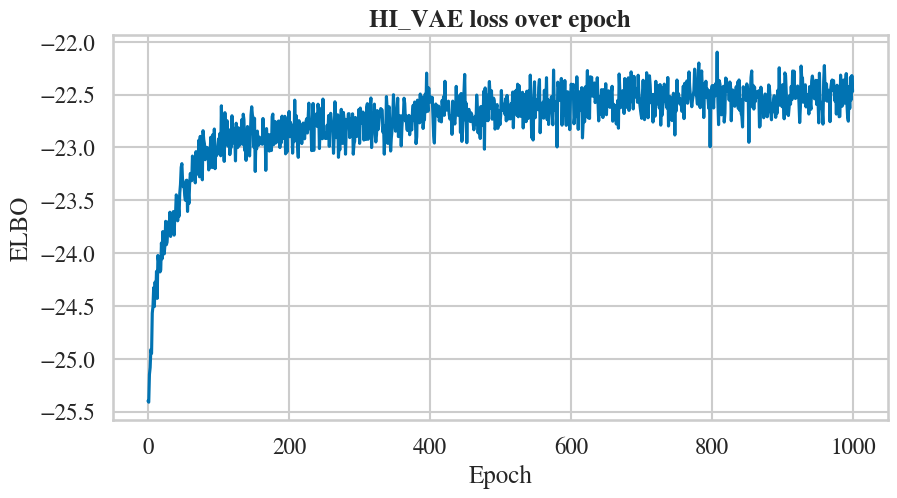

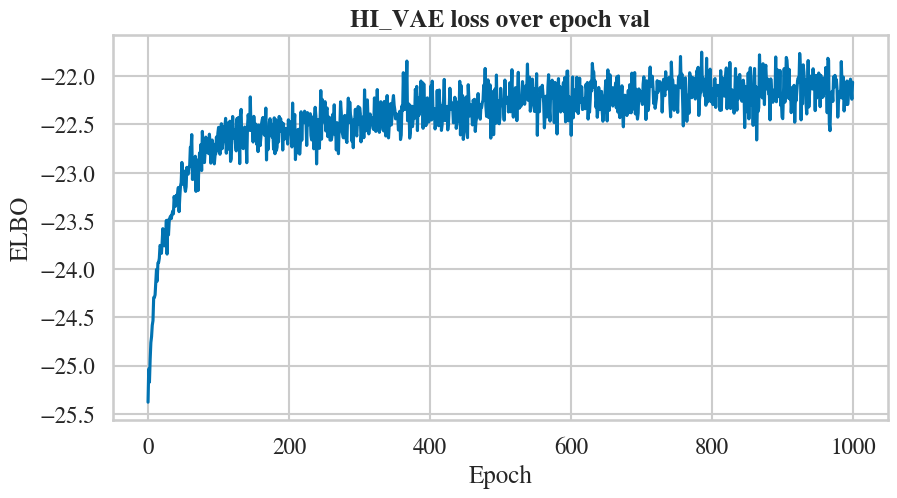

In [65]:
start_time = time.time()
loss_train, error_observed_train, error_missing_train = [], [], []
loss_val, error_observed_val, error_missing_val = [], [], []

for epoch in range(epochs):
    avg_loss, avg_KL_s, avg_KL_z = 0.0, 0.0, 0.0
    avg_loss_val, avg_KL_s_val, avg_KL_z_val = 0.0, 0.0, 0.0
    samples_list, p_params_list, q_params_list, log_p_x_total, log_p_x_missing_total = [], [], [], [], []
    tau = max(1.0 - 0.01 * epoch, 1e-3)

    # Shuffle training data
    perm = np.random.permutation(data_train.shape[0])
    data_train = data_train[perm]
    miss_mask_train = miss_mask_train[perm]
    true_miss_mask_train = true_miss_mask_train[perm]

    for i in range(n_batches_train):
        # Get batch data
        data_list, miss_list = data_processing.next_batch(data_train, feat_types_dict, miss_mask_train, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]


        # Compute loss
        optimizer.zero_grad()
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau, n_generated_sample=1)
        vae_res["neg_ELBO_loss"].backward()
        optimizer.step()

        with torch.no_grad():

            avg_loss += vae_res["neg_ELBO_loss"].item() / n_batches_train
            avg_KL_s += torch.mean(vae_res["KL_s"]).item() / n_batches_train
            avg_KL_z += torch.mean(vae_res["KL_z"]).item() / n_batches_train

            
            for i in range(n_batches_test):
                data_list_test, miss_list_test = data_processing.next_batch(data_test, feat_types_dict, miss_mask_test, batch_test_size, i)
            
                # Mask unknown data (set unobserved values to zero)
                data_list_observed_test = [data * miss_list_test[:, i].view(batch_test_size, 1) for i, data in enumerate(data_list_test)]
            
                vae_res_test = vae_model.forward(data_list_observed_test, data_list_test, miss_list_test, tau=1e-3, n_generated_sample=1)
                avg_loss_val += vae_res_test["neg_ELBO_loss"].item() / n_batches_train
                avg_KL_s_val += torch.mean(vae_res_test["KL_s"]).item() / n_batches_train
                avg_KL_z_val += torch.mean(vae_res_test["KL_z"]).item() / n_batches_train
                #print(avg_loss_val)
            
            
     

        # Save the generated samlpes and estimated parameters !
        samples_list.append(vae_res["samples"])
        p_params_list.append(vae_res["p_params"])
        q_params_list.append(vae_res["q_params"])
        log_p_x_total.append(vae_res["log_p_x"])
        log_p_x_missing_total.append(vae_res["log_p_x_missing"])


    #Concatenate samples in arrays
    s_total, z_total, y_total, est_data_train = statistic.samples_concatenation(samples_list)
    
    # Transform discrete variables back to the original values
    data_train_transformed = data_processing.discrete_variables_transformation(data_train[: n_train_samples], feat_types_dict)
    est_data_train_transformed = data_processing.discrete_variables_transformation(est_data_train[0], feat_types_dict)
    # est_data_train_mean_imputed = statistic.mean_imputation(data_train_transformed, miss_mask_train[: n_train_samples], feat_types_dict)

    # Compute errors
    error_observed_samples, error_missing_samples = statistic.error_computation(data_train_transformed, est_data_train_transformed, feat_types_dict, miss_mask[:n_train_samples])
    
    # # #Create global dictionary of the distribution parameters
    q_params_complete = statistic.q_distribution_params_concatenation(q_params_list)
    
    #Number of clusters created
    cluster_index = torch.argmax(q_params_complete['s'], 1)
    cluster = torch.unique(cluster_index)
    #print('Clusters: ' + str(len(cluster)))

    # Save average loss and error
    loss_train.append(avg_loss)
    loss_val.append(avg_loss_val)
    error_observed_train.append(torch.mean(error_observed_samples))
    error_missing_train.append(torch.mean(error_missing_samples))

    if epoch % 100 == 0:
        visualization.print_loss(epoch, start_time, -avg_loss, avg_KL_s, avg_KL_z)
        visualization.print_loss(epoch, start_time, -avg_loss_val, avg_KL_s_val, avg_KL_z_val)



print("Training finished.")

torch.save(vae_model.state_dict(), network_file)

visualization.plot_loss_evolution(-np.array(loss_train), title = "HI_VAE loss over epoch",
                                xlabel = "Epoch", ylabel = "ELBO")
visualization.plot_loss_evolution(-np.array(loss_val), title = "HI_VAE loss over epoch val",
                                xlabel = "Epoch", ylabel = "ELBO")


In [66]:
len(data_list)

8

In [67]:
miss_list.shape

torch.Size([100, 8])

### Visualize the generated samples

In [68]:
data.shape

torch.Size([440, 12])

### Statistical analysis with simulated data

In [69]:
data_forgen = data#[train_index]
miss_mask_forgen = miss_mask#[train_index]
true_miss_mask_forgen = true_miss_mask#[train_index]

In [70]:
miss_mask_forgen.shape

torch.Size([440, 8])

In [71]:
data_forgen.shape

torch.Size([440, 12])

#### Generate from original sample

In [72]:
n_samples_forgen = data_forgen.shape[0]
batch_size = n_samples_forgen
print(n_samples_forgen)
# Number of batches
n_batches_generation = 1

# Compute real missing mask
miss_mask_forgen = torch.multiply(miss_mask_forgen, true_miss_mask_forgen)

# Number of samples generated by one input data
n_generated_sample = 10

with torch.no_grad(): 
    
    error_mode_global = 0.0
    avg_loss = 0.0
    samples_list = []
    
    for i in range(n_batches_generation):
        data_list, miss_list = data_processing.next_batch(data_forgen, feat_types_dict, miss_mask_forgen, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]
        
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau=1e-3, n_generated_sample=n_generated_sample)
        samples_list.append(vae_res["samples"])
    
    
    #Concatenate samples in arrays
    est_data_gen = statistic.samples_concatenation(samples_list)[-1]
    est_data_gen_transformed = []
    for j in range(n_generated_sample):
        data_trans = data_processing.discrete_variables_transformation(est_data_gen[j], feat_types_dict)
        data_trans = data_processing.survival_variables_transformation(data_trans,feat_types_dict)
        est_data_gen_transformed.append(data_trans.unsqueeze(0))
        
    est_data_gen_transformed = torch.cat(est_data_gen_transformed, dim=0)

440


survcens
age
estrec
menostat
pnodes
progrec
tgrade
tsize


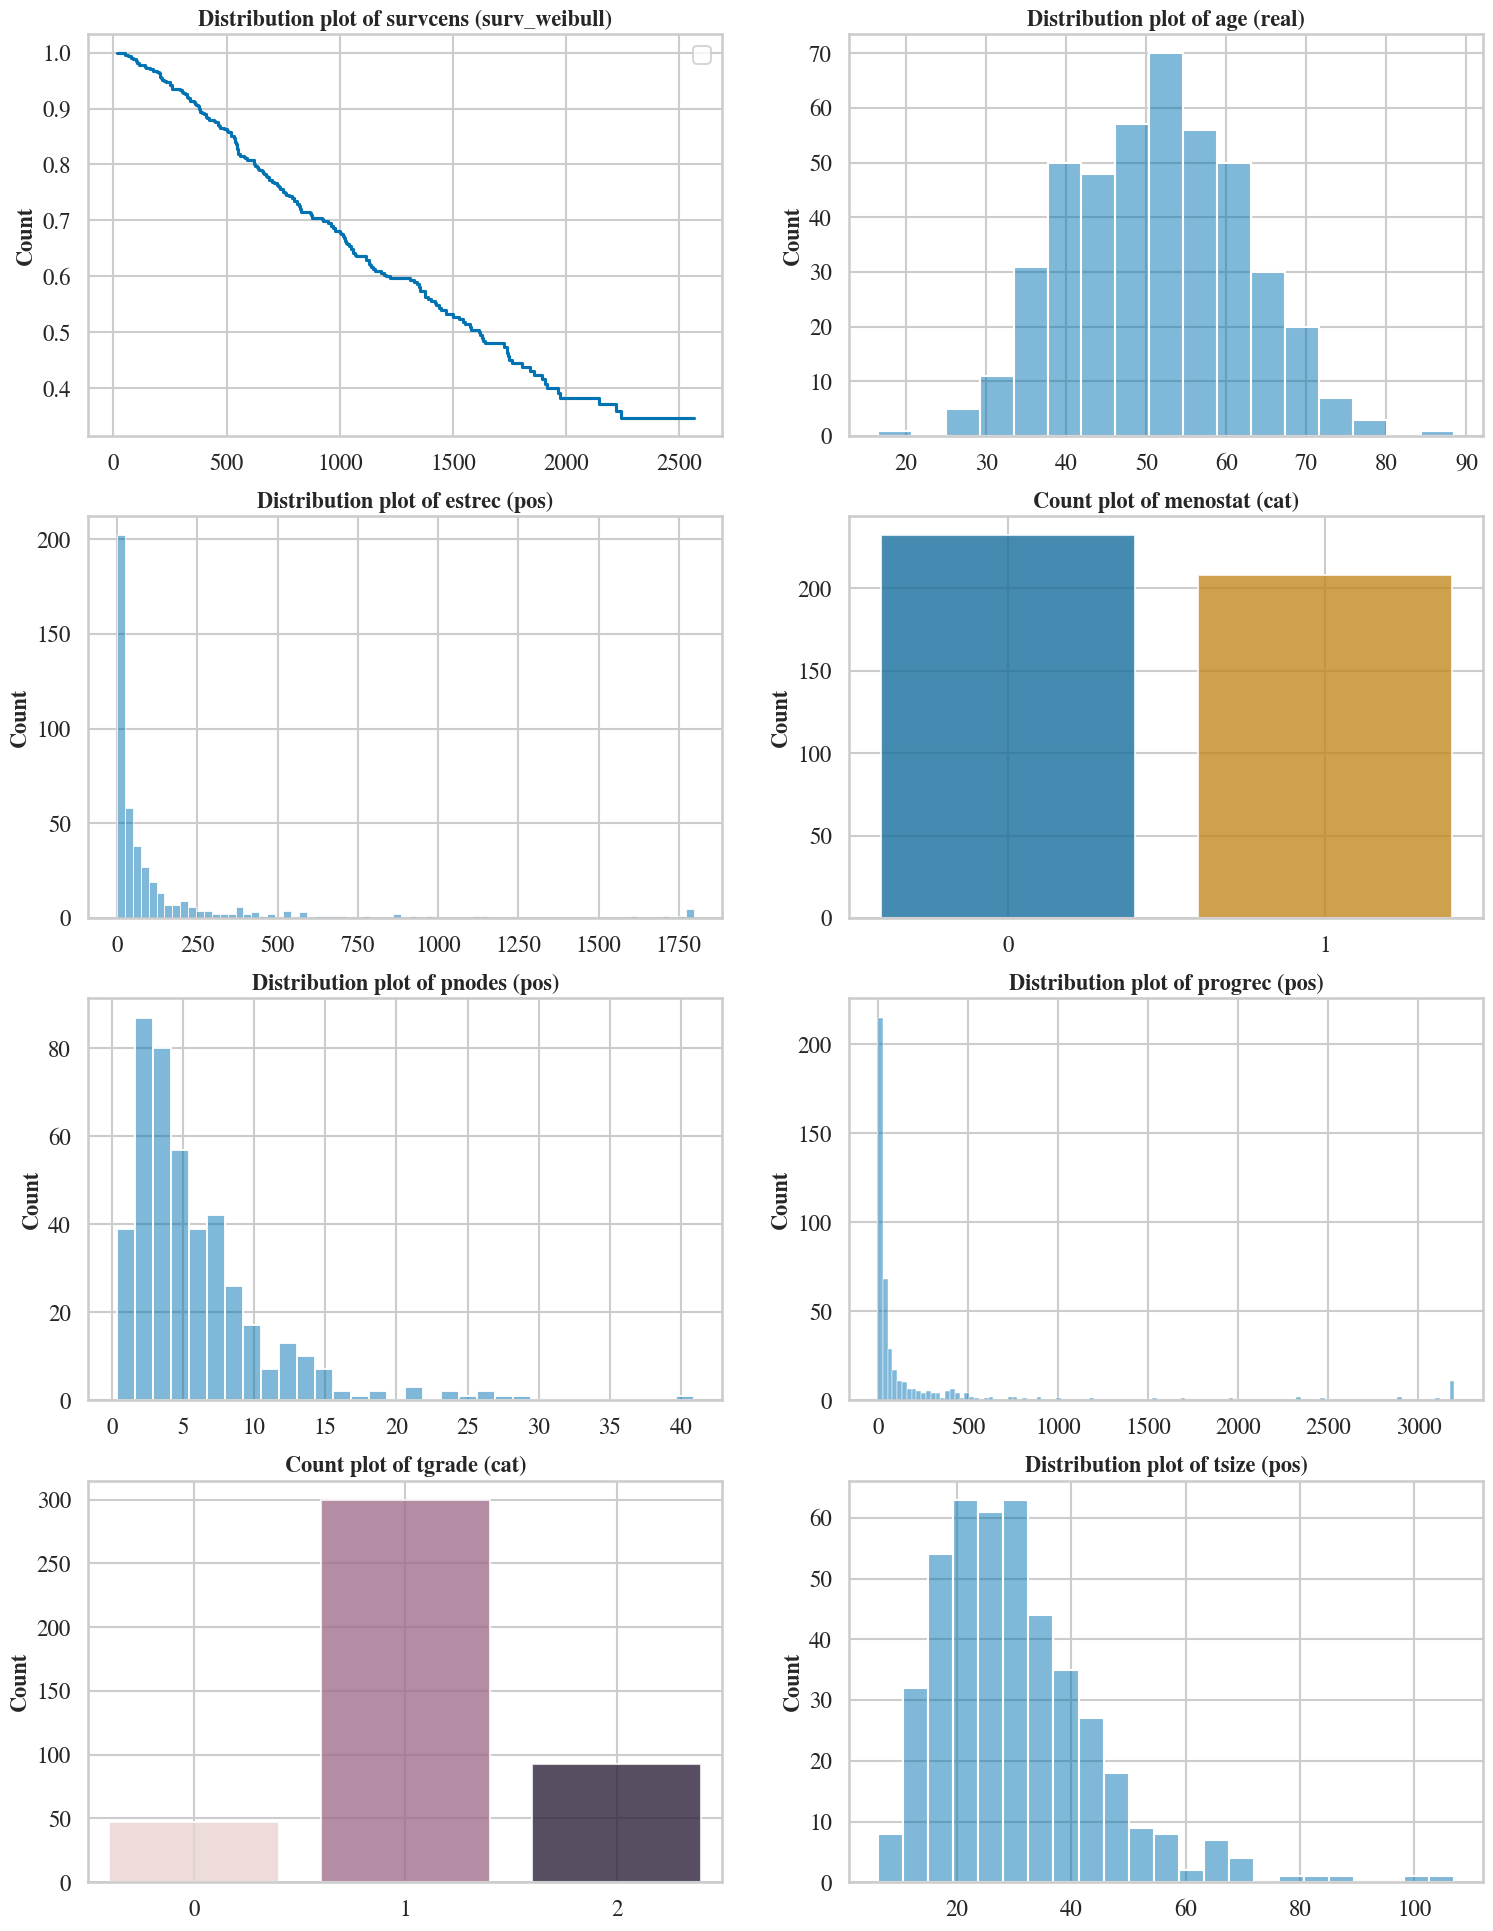

In [83]:
# Call plotting function
visualization.plot_data(est_data_gen_transformed[5], feat_types_dict)


In [84]:
df_transformed_initial = pd.DataFrame(data_transformed_control.numpy(), columns=gbsb2_control_columns)
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[0].numpy(), columns=gbsb2_control_columns)
df_transformed_initial["sample"]=1
df_transformed_generated["sample"]=0
df_transformed_initial_generated = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)

In [85]:
categorical = []
continuous = []
nonnormal = []
for index, row in pd.read_csv(feat_types_file_control).iterrows():
    if row['type'] == 'cat':
        categorical.append(row['name'])
    elif row['type'] in ['real','pos','count']:
        continuous.append(row['name'])
        if row['type'] in ['pos','count']:
            nonnormal.append(row['name'])
categorical.append('censor')
categorical.append('treatment')
continuous.append('time')
nonnormal.append('time')

categorical.remove('treatment')
categorical.append('sample')

In [86]:
table1 = TableOne(df_transformed_initial_generated, categorical=categorical, continuous=continuous, groupby='sample',nonnormal=nonnormal, pval=True)
print(table1)

                            Grouped by sample                                                                           
                                      Missing               Overall                      0                     1 P-Value
n                                                               880                    440                   440        
time, median [Q1,Q3]                        0  988.5 [549.9,1584.4]  1038.3 [557.7,1589.7]  967.0 [547.8,1573.0]   0.489
censor, n (%)           0.0                              477 (54.2)             242 (55.0)            235 (53.4)   0.685
                        1.0                              403 (45.8)             198 (45.0)            205 (46.6)        
age, mean (SD)                              0           51.3 (10.8)            51.6 (11.5)           51.1 (10.0)   0.478
estrec, median [Q1,Q3]                      0       30.7 [8.0,99.3]       29.0 [8.5,120.0]       32.0 [8.0,92.2]   0.206
menostat, n (%)         0.0     

In [87]:
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[3].numpy(), columns=gbsb2_control_columns)
df_transformed_generated['treatment'] = 0
df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
#df_transformed_T_Cgen = df_transformed_T_Cgen.drop('sample',axis=1)
#df_transformed_T_Cgen.head()

In [88]:
#df_transformed_all.head()

In [89]:
categorical.append('treatment')
categorical.remove('sample')
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                            Grouped by treatment                                                                            
                                         Missing                Overall                     0                      1 P-Value
n                                                                   686                   440                    246        
time, median [Q1,Q3]                           0  1084.0 [567.8,1684.8]  967.0 [547.8,1573.0]  1220.5 [695.8,1818.0]   0.001
censor, n (%)           0.0                                  387 (56.4)            235 (53.4)             152 (61.8)   0.041
                        1.0                                  299 (43.6)            205 (46.6)              94 (38.2)        
age, mean (SD)                                 0            53.1 (10.1)           51.1 (10.0)             56.6 (9.4)  <0.001
estrec, median [Q1,Q3]                         0       36.0 [8.0,114.0]       32.0 [8.0,92.2]       46.0 [9.0,182.5]   0.009


In [90]:
table1 = TableOne(df_transformed_T_Cgen, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                            Grouped by treatment                                                                             
                                         Missing                Overall                      0                      1 P-Value
n                                                                   686                    440                    246        
time, median [Q1,Q3]                           0  1054.0 [566.8,1674.8]  1001.2 [533.6,1494.7]  1220.5 [695.8,1818.0]   0.003
censor, n (%)           0.0                                  388 (56.6)             236 (53.6)             152 (61.8)   0.047
                        1.0                                  298 (43.4)             204 (46.4)              94 (38.2)        
age, mean (SD)                                 0            53.4 (11.0)            51.7 (11.5)             56.6 (9.4)  <0.001
estrec, median [Q1,Q3]                         0       33.8 [7.6,134.8]       28.7 [6.7,116.0]       46.0 [9.0,182.5] 

In [91]:
df_transformed_all.head()

,time,censor,age,estrec,menostat,pnodes,progrec,tgrade,tsize,treatment
0,1814.0,1.0,70.0,66.0,1.0,3.0,48.0,1.0,21.0,0
1,772.0,1.0,73.0,65.0,1.0,1.0,26.0,1.0,35.0,0
2,448.0,1.0,32.0,13.0,0.0,24.0,0.0,2.0,57.0,0
3,2161.0,0.0,65.0,25.0,1.0,1.0,192.0,1.0,16.0,0
4,471.0,1.0,80.0,59.0,1.0,30.0,0.0,1.0,39.0,0


Text(0.5, 0, 'time $t$')

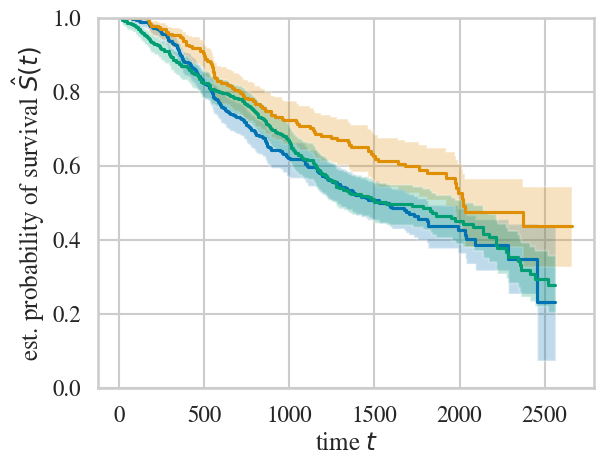

In [92]:

time_initial_C, survival_prob_initial_C, conf_int_initial_C = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==0]['censor'].to_numpy()==1, 
    df_transformed_all[df_transformed_all['treatment']==0]['time'].to_numpy(), conf_type="log-log"
)

time_initial_T, survival_prob_initial_T, conf_int_initial_T = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==1]['censor'].to_numpy()==1, 
    df_transformed_all[df_transformed_all['treatment']==1]['time'].to_numpy(), conf_type="log-log"
)

time_T_Cgen_C, survival_prob_T_Cgen_C, conf_int_T_Cgen_C = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0]['censor'].to_numpy()==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0]['time'].to_numpy(), conf_type="log-log"
)

time_T_Cgen_T, survival_prob_T_Cgen_T, conf_int_T_Cgen_T = kaplan_meier_estimator(
   df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1]['censor'].to_numpy()==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1]['time'].to_numpy(), conf_type="log-log"
)


plt.step(time_initial_C, survival_prob_initial_C, where="post")
plt.fill_between(time_initial_C, conf_int_initial_C[0], conf_int_initial_C[1], alpha=0.25, step="post")

plt.step(time_initial_T, survival_prob_initial_T, where="post")
plt.fill_between(time_initial_T, conf_int_initial_T[0], conf_int_initial_T[1], alpha=0.25, step="post")


plt.step(time_T_Cgen_C, survival_prob_T_Cgen_C, where="post")
plt.fill_between(time_T_Cgen_C, conf_int_T_Cgen_C[0], conf_int_T_Cgen_C[1], alpha=0.25, step="post")


#plt.step(time_T_Cgen_T, survival_prob_T_Cgen_T, where="post")
#plt.fill_between(time_T_Cgen_T, conf_int_T_Cgen_T[0], conf_int_T_Cgen_T[1], alpha=0.25, step="post")

plt.ylim( 0,1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [93]:
df_transformed_all

,time,censor,age,estrec,menostat,pnodes,progrec,tgrade,tsize,treatment
0,1814.0,1.0,70.0,66.0,1.0,3.0,48.0,1.0,21.0,0
1,772.0,1.0,73.0,65.0,1.0,1.0,26.0,1.0,35.0,0
2,448.0,1.0,32.0,13.0,0.0,24.0,0.0,2.0,57.0,0
3,2161.0,0.0,65.0,25.0,1.0,1.0,192.0,1.0,16.0,0
4,471.0,1.0,80.0,59.0,1.0,30.0,0.0,1.0,39.0,0
...,...,...,...,...,...,...,...,...,...,...
681,1219.0,0.0,56.0,174.0,1.0,2.0,53.0,1.0,32.0,1
682,662.0,1.0,56.0,700.0,1.0,5.0,113.0,0.0,42.0,1
683,974.0,0.0,61.0,346.0,1.0,5.0,141.0,1.0,27.0,1
684,504.0,1.0,60.0,11.0,1.0,6.0,8.0,1.0,40.0,1


In [94]:
list_cov

NameError: name 'list_cov' is not defined

In [114]:
def encode_and_bind(original_dataframe, feature_to_encode):
    #print(np.unique(original_dataframe[feature_to_encode]))#.shape[0])
    if np.unique(original_dataframe[feature_to_encode]).shape[0] > 2 :
        dummies = pd.get_dummies(original_dataframe[feature_to_encode],drop_first=True, prefix=feature_to_encode, prefix_sep='',dtype=int)
        res = pd.concat([original_dataframe, dummies], axis=1)
        #print(res.head())
        res = res.drop([feature_to_encode], axis=1)
    else:
        res = original_dataframe
    return(res) 

categorical_encode = ['menostat', 'tgrade','treatment']


In [115]:
df_transformed_all_oh = df_transformed_all.copy()
for feat in categorical_encode:
    df_transformed_all_oh = encode_and_bind(df_transformed_all_oh,feat)

In [116]:
df_transformed_all_oh.head()

,age,estrec,menostat,pnodes,progrec,tsize,time,censor,treatment,tgrade1.0,tgrade2.0
0,70.0,66.0,1.0,3.0,49.0,21.0,1814.0,1.0,0,1,0
1,73.0,65.0,1.0,1.0,27.0,35.0,772.0,1.0,0,1,0
2,32.0,13.0,0.0,24.0,1.0,57.0,448.0,1.0,0,0,1
3,65.0,25.0,1.0,1.0,193.0,16.0,2161.0,0.0,0,1,0
4,80.0,59.0,1.0,30.0,1.0,39.0,471.0,1.0,0,1,0


In [117]:
X_initial = np.delete(df_transformed_all_oh.to_numpy(),[6,7],axis=1)
Y_initial = Surv.from_arrays(df_transformed_all_oh.to_numpy()[:,7]==1,df_transformed_all.to_numpy()[:,6])
print(compare_survival(Y_initial,X_initial[:,6]))
for i in np.arange(n_generated_sample):
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=gbsb2_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = encode_and_bind(df_transformed_T_Cgen_oh,feat)
    
    X_T_Cgen = np.delete(df_transformed_T_Cgen_oh.to_numpy(),[6,7],axis=1)
    Y_T_Cgen = Surv.from_arrays(df_transformed_T_Cgen_oh.to_numpy()[:,7]==1,df_transformed_T_Cgen_oh.to_numpy()[:,6])
    print(compare_survival(Y_T_Cgen,X_T_Cgen[:,6]))

(1.3268884990153336, 0.24935951222441508)
(6.991755455548982, 0.008188600404199536)
(10.828078423837944, 0.0009997233743616464)
(1.591244940829169, 0.2071483566597659)
(7.2658973656405745, 0.007027614713053996)
(6.0377982904500955, 0.014002736866556122)
(6.59176317627858, 0.01024516536406241)
(7.223476261677722, 0.007195622466611502)
(3.844551770186429, 0.0499078597300821)
(6.009480087898528, 0.014229219432339874)
(6.576070935069381, 0.010335879500721495)


In [125]:
# Fit the Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(df_transformed_all_oh, duration_col='time', event_col='censor')

# Display summary statistics of the model
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
             duration col = 'time'
                event col = 'censor'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 299
   partial log-likelihood = -1735.73
         time fit was run = 2025-03-12 17:58:47 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age       -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
estrec     0.00      1.00      0.00           -0.00            0.00                1.00                1.00
menostat   0.26      1.29      0.18           -0.10            0.62                0.90                1.86
pnodes     0.05      1.05      0.01            0.03            0.06                1.03                1.07
progrec   -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
tsize      0.01      1.01      0.00            0.00            0.02                1.00                1.02
treatment -0.35      0.71      0.13           -0.60           -0.09                0.55                0.91
tgrade1.0  0.64      1.89      0.25            0.15            1.12                1.16                3.08
tgrade2.0  0.78      2.18      0.27            0.25            1.31                1.29                3.69

           cmp to     z      p  -log2(p)
covariate                               
age          0.00 -1.02   0.31      1.69
estrec       0.00  0.44   0.66      0.60
menostat     0.00  1.41   0.16      2.65
pnodes       0.00  6.55 <0.005     34.03
progrec      0.00 -3.87 <0.005     13.14
tsize        0.00  1.98   0.05      4.39
treatment    0.00 -2.68   0.01      7.10
tgrade1.0    0.00  2.55   0.01      6.55
tgrade2.0    0.00  2.90 <0.005      8.08
---
Concordance = 0.69
Partial AIC = 3489.46
log-likelihood ratio test = 104.75 on 9 df
-log2(p) of ll-ratio test = 59.01

In [126]:
for i in np.arange(n_generated_sample):
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=gbsb2_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = encode_and_bind(df_transformed_T_Cgen_oh,feat)
    cph_g = CoxPHFitter()
    cph_g.fit(df_transformed_T_Cgen_oh, duration_col='time', event_col='censor')

    # Display summary statistics of the model
    print(cph_g.print_summary())
    

<lifelines.CoxPHFitter: fitted with 686 total observations, 398 right-censored observations>
             duration col = 'time'
                event col = 'censor'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 288
   partial log-likelihood = -1661.52
         time fit was run = 2025-03-12 18:00:30 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age       -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
estrec    -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
menostat   0.14      1.15      0.14           -0.14            0.41                0.87                1.51
pnodes     0.06      1.06      0.01            0.03            0.09                1.03                1.09
progrec   -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
tsize      0.00      1.00      0.01           -0.01            0.01                0.99                1.01
treatment -0.24      0.79      0.13           -0.50            0.02                0.60                1.02
tgrade1.0  0.29      1.34      0.22           -0.15            0.73                0.86                2.07
tgrade2.0  0.63      1.88      0.24            0.16            1.10                1.17                3.02

           cmp to     z      p  -log2(p)
covariate                               
age          0.00 -0.87   0.38      1.39
estrec       0.00 -0.10   0.92      0.11
menostat     0.00  0.98   0.32      1.62
pnodes       0.00  4.47 <0.005     16.93
progrec      0.00 -3.94 <0.005     13.56
tsize        0.00  0.28   0.78      0.37
treatment    0.00 -1.82   0.07      3.85
tgrade1.0    0.00  1.30   0.19      2.36
tgrade2.0    0.00  2.61   0.01      6.80
---
Concordance = 0.66
Partial AIC = 3341.03
log-likelihood ratio test = 78.13 on 9 df
-log2(p) of ll-ratio test = 41.26

None


<lifelines.CoxPHFitter: fitted with 686 total observations, 391 right-censored observations>
             duration col = 'time'
                event col = 'censor'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 295
   partial log-likelihood = -1707.05
         time fit was run = 2025-03-12 18:00:30 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age       -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
estrec    -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
menostat  -0.04      0.96      0.13           -0.30            0.22                0.74                1.25
pnodes     0.06      1.06      0.01            0.03            0.09                1.03                1.09
progrec   -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
tsize     -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
treatment -0.33      0.72      0.13           -0.59           -0.07                0.56                0.93
tgrade1.0  0.36      1.44      0.22           -0.07            0.79                0.94                2.20
tgrade2.0  0.55      1.73      0.24            0.07            1.02                1.08                2.77

           cmp to     z      p  -log2(p)
covariate                               
age          0.00 -0.34   0.73      0.45
estrec       0.00 -1.06   0.29      1.78
menostat     0.00 -0.32   0.75      0.41
pnodes       0.00  4.25 <0.005     15.51
progrec      0.00 -3.94 <0.005     13.57
tsize        0.00 -0.27   0.79      0.34
treatment    0.00 -2.52   0.01      6.43
tgrade1.0    0.00  1.66   0.10      3.36
tgrade2.0    0.00  2.26   0.02      5.39
---
Concordance = 0.64
Partial AIC = 3432.10
log-likelihood ratio test = 75.60 on 9 df
-log2(p) of ll-ratio test = 39.60

None


<lifelines.CoxPHFitter: fitted with 686 total observations, 417 right-censored observations>
             duration col = 'time'
                event col = 'censor'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 269
   partial log-likelihood = -1536.72
         time fit was run = 2025-03-12 18:00:30 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.01      1.01      0.01           -0.01            0.02                0.99                1.02
estrec     0.00      1.00      0.00           -0.00            0.00                1.00                1.00
menostat  -0.20      0.82      0.14           -0.48            0.08                0.62                1.09
pnodes     0.07      1.08      0.01            0.05            0.10                1.05                1.11
progrec   -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
tsize     -0.01      0.99      0.01           -0.02            0.00                0.98                1.00
treatment -0.07      0.93      0.14           -0.33            0.20                0.72                1.22
tgrade1.0 -0.07      0.93      0.19           -0.44            0.30                0.64                1.35
tgrade2.0  0.41      1.50      0.21           -0.01            0.83                0.99                2.29

           cmp to     z      p  -log2(p)
covariate                               
age          0.00  1.04   0.30      1.75
estrec       0.00  0.43   0.67      0.59
menostat     0.00 -1.37   0.17      2.55
pnodes       0.00  5.51 <0.005     24.72
progrec      0.00 -4.02 <0.005     14.05
tsize        0.00 -1.90   0.06      4.12
treatment    0.00 -0.51   0.61      0.71
tgrade1.0    0.00 -0.37   0.71      0.50
tgrade2.0    0.00  1.90   0.06      4.12
---
Concordance = 0.68
Partial AIC = 3091.44
log-likelihood ratio test = 87.49 on 9 df
-log2(p) of ll-ratio test = 47.45

None


<lifelines.CoxPHFitter: fitted with 686 total observations, 393 right-censored observations>
             duration col = 'time'
                event col = 'censor'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 293
   partial log-likelihood = -1695.69
         time fit was run = 2025-03-12 18:00:30 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.01      1.01      0.01           -0.00            0.02                1.00                1.02
estrec    -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
menostat  -0.12      0.88      0.14           -0.39            0.15                0.68                1.16
pnodes     0.07      1.07      0.01            0.05            0.10                1.05                1.10
progrec   -0.00      1.00      0.00           -0.01           -0.00                0.99                1.00
tsize      0.00      1.00      0.01           -0.01            0.01                0.99                1.01
treatment -0.25      0.78      0.13           -0.51            0.01                0.60                1.01
tgrade1.0  0.20      1.22      0.20           -0.20            0.59                0.82                1.81
tgrade2.0  0.53      1.70      0.22            0.09            0.96                1.10                2.62

           cmp to     z      p  -log2(p)
covariate                               
age          0.00  1.33   0.18      2.44
estrec       0.00 -0.02   0.98      0.02
menostat     0.00 -0.89   0.37      1.43
pnodes       0.00  5.59 <0.005     25.43
progrec      0.00 -3.68 <0.005     12.06
tsize        0.00  0.36   0.72      0.48
treatment    0.00 -1.86   0.06      4.00
tgrade1.0    0.00  0.97   0.33      1.58
tgrade2.0    0.00  2.38   0.02      5.86
---
Concordance = 0.66
Partial AIC = 3409.39
log-likelihood ratio test = 80.62 on 9 df
-log2(p) of ll-ratio test = 42.90

None


<lifelines.CoxPHFitter: fitted with 686 total observations, 404 right-censored observations>
             duration col = 'time'
                event col = 'censor'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 282
   partial log-likelihood = -1619.30
         time fit was run = 2025-03-12 18:00:30 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age       -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
estrec    -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
menostat   0.07      1.08      0.14           -0.20            0.35                0.82                1.42
pnodes     0.06      1.07      0.01            0.04            0.09                1.04                1.10
progrec   -0.00      1.00      0.00           -0.01           -0.00                0.99                1.00
tsize      0.00      1.00      0.01           -0.01            0.01                0.99                1.01
treatment -0.24      0.78      0.13           -0.51            0.02                0.60                1.02
tgrade1.0  0.19      1.21      0.22           -0.24            0.63                0.79                1.87
tgrade2.0  0.60      1.81      0.24            0.12            1.07                1.13                2.91

           cmp to     z      p  -log2(p)
covariate                               
age          0.00 -0.00   1.00      0.00
estrec       0.00 -1.75   0.08      3.64
menostat     0.00  0.53   0.60      0.74
pnodes       0.00  4.73 <0.005     18.76
progrec      0.00 -3.64 <0.005     11.84
tsize        0.00  0.45   0.66      0.61
treatment    0.00 -1.82   0.07      3.85
tgrade1.0    0.00  0.88   0.38      1.40
tgrade2.0    0.00  2.48   0.01      6.23
---
Concordance = 0.66
Partial AIC = 3256.61
log-likelihood ratio test = 82.31 on 9 df
-log2(p) of ll-ratio test = 44.02

None


<lifelines.CoxPHFitter: fitted with 686 total observations, 394 right-censored observations>
             duration col = 'time'
                event col = 'censor'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 292
   partial log-likelihood = -1690.38
         time fit was run = 2025-03-12 18:00:31 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.00      1.00      0.01           -0.01            0.02                0.99                1.02
estrec    -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
menostat   0.06      1.06      0.14           -0.21            0.32                0.81                1.38
pnodes     0.06      1.07      0.01            0.04            0.09                1.04                1.09
progrec   -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
tsize      0.00      1.00      0.01           -0.01            0.01                0.99                1.01
treatment -0.25      0.78      0.13           -0.52            0.01                0.60                1.01
tgrade1.0  0.04      1.04      0.20           -0.36            0.43                0.70                1.54
tgrade2.0  0.21      1.23      0.22           -0.23            0.65                0.79                1.91

           cmp to     z      p  -log2(p)
covariate                               
age          0.00  0.79   0.43      1.23
estrec       0.00 -0.46   0.64      0.63
menostat     0.00  0.43   0.67      0.58
pnodes       0.00  4.84 <0.005     19.59
progrec      0.00 -3.85 <0.005     13.06
tsize        0.00  0.95   0.34      1.54
treatment    0.00 -1.89   0.06      4.10
tgrade1.0    0.00  0.18   0.86      0.22
tgrade2.0    0.00  0.93   0.35      1.49
---
Concordance = 0.64
Partial AIC = 3398.76
log-likelihood ratio test = 68.37 on 9 df
-log2(p) of ll-ratio test = 34.87

None


<lifelines.CoxPHFitter: fitted with 686 total observations, 392 right-censored observations>
             duration col = 'time'
                event col = 'censor'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 294
   partial log-likelihood = -1694.84
         time fit was run = 2025-03-12 18:00:31 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.01      1.01      0.01           -0.01            0.02                0.99                1.02
estrec    -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
menostat   0.02      1.02      0.13           -0.24            0.28                0.79                1.32
pnodes     0.07      1.07      0.01            0.05            0.10                1.05                1.10
progrec   -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
tsize     -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
treatment -0.27      0.77      0.13           -0.53           -0.01                0.59                0.99
tgrade1.0  0.24      1.28      0.22           -0.19            0.68                0.82                1.97
tgrade2.0  0.44      1.55      0.24           -0.04            0.91                0.96                2.49

           cmp to     z      p  -log2(p)
covariate                               
age          0.00  1.01   0.31      1.68
estrec       0.00 -0.02   0.99      0.02
menostat     0.00  0.14   0.89      0.17
pnodes       0.00  5.36 <0.005     23.54
progrec      0.00 -3.92 <0.005     13.44
tsize        0.00 -0.68   0.50      1.00
treatment    0.00 -2.00   0.05      4.46
tgrade1.0    0.00  1.10   0.27      1.87
tgrade2.0    0.00  1.80   0.07      3.80
---
Concordance = 0.65
Partial AIC = 3407.69
log-likelihood ratio test = 76.91 on 9 df
-log2(p) of ll-ratio test = 40.46

None


<lifelines.CoxPHFitter: fitted with 686 total observations, 408 right-censored observations>
             duration col = 'time'
                event col = 'censor'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 278
   partial log-likelihood = -1606.09
         time fit was run = 2025-03-12 18:00:31 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age       -0.01      0.99      0.01           -0.02            0.00                0.98                1.00
estrec    -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
menostat   0.09      1.10      0.14           -0.18            0.37                0.84                1.44
pnodes     0.08      1.08      0.01            0.05            0.11                1.06                1.11
progrec   -0.00      1.00      0.00           -0.01           -0.00                0.99                1.00
tsize     -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
treatment -0.18      0.83      0.14           -0.45            0.08                0.64                1.08
tgrade1.0  0.03      1.03      0.21           -0.37            0.44                0.69                1.55
tgrade2.0  0.19      1.21      0.23           -0.26            0.64                0.77                1.91

           cmp to     z      p  -log2(p)
covariate                               
age          0.00 -1.48   0.14      2.85
estrec       0.00 -1.21   0.23      2.14
menostat     0.00  0.67   0.50      1.00
pnodes       0.00  5.93 <0.005     28.28
progrec      0.00 -3.68 <0.005     12.08
tsize        0.00 -0.12   0.91      0.14
treatment    0.00 -1.37   0.17      2.54
tgrade1.0    0.00  0.16   0.87      0.20
tgrade2.0    0.00  0.83   0.40      1.31
---
Concordance = 0.66
Partial AIC = 3230.18
log-likelihood ratio test = 75.78 on 9 df
-log2(p) of ll-ratio test = 39.71

None


<lifelines.CoxPHFitter: fitted with 686 total observations, 395 right-censored observations>
             duration col = 'time'
                event col = 'censor'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 291
   partial log-likelihood = -1671.51
         time fit was run = 2025-03-12 18:00:31 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.00      1.00      0.01           -0.01            0.01                0.99                1.01
estrec     0.00      1.00      0.00           -0.00            0.00                1.00                1.00
menostat  -0.04      0.96      0.14           -0.31            0.23                0.73                1.26
pnodes     0.09      1.09      0.01            0.06            0.11                1.06                1.12
progrec   -0.00      1.00      0.00           -0.01           -0.00                0.99                1.00
tsize     -0.01      0.99      0.01           -0.02            0.00                0.98                1.00
treatment -0.27      0.77      0.14           -0.53           -0.00                0.59                1.00
tgrade1.0  0.44      1.55      0.22            0.01            0.87                1.01                2.39
tgrade2.0  0.50      1.65      0.24            0.03            0.97                1.03                2.64

           cmp to     z      p  -log2(p)
covariate                               
age          0.00  0.11   0.91      0.13
estrec       0.00  0.89   0.38      1.41
menostat     0.00 -0.29   0.77      0.38
pnodes       0.00  6.92 <0.005     37.73
progrec      0.00 -3.72 <0.005     12.27
tsize        0.00 -1.08   0.28      1.84
treatment    0.00 -1.97   0.05      4.34
tgrade1.0    0.00  2.02   0.04      4.52
tgrade2.0    0.00  2.08   0.04      4.74
---
Concordance = 0.67
Partial AIC = 3361.02
log-likelihood ratio test = 85.66 on 9 df
-log2(p) of ll-ratio test = 46.24

None


<lifelines.CoxPHFitter: fitted with 686 total observations, 397 right-censored observations>
             duration col = 'time'
                event col = 'censor'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 289
   partial log-likelihood = -1671.54
         time fit was run = 2025-03-12 18:00:31 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age       -0.01      0.99      0.01           -0.02            0.00                0.98                1.00
estrec     0.00      1.00      0.00           -0.00            0.00                1.00                1.00
menostat   0.13      1.14      0.14           -0.14            0.40                0.87                1.49
pnodes     0.07      1.08      0.01            0.05            0.10                1.05                1.10
progrec   -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
tsize     -0.01      0.99      0.01           -0.02            0.00                0.98                1.00
treatment -0.24      0.78      0.13           -0.51            0.02                0.60                1.02
tgrade1.0  0.25      1.29      0.21           -0.16            0.67                0.85                1.95
tgrade2.0  0.37      1.45      0.23           -0.08            0.83                0.92                2.29

           cmp to     z      p  -log2(p)
covariate                               
age          0.00 -1.27   0.20      2.30
estrec       0.00  0.62   0.54      0.90
menostat     0.00  0.94   0.35      1.53
pnodes       0.00  5.38 <0.005     23.72
progrec      0.00 -3.88 <0.005     13.21
tsize        0.00 -1.10   0.27      1.89
treatment    0.00 -1.82   0.07      3.85
tgrade1.0    0.00  1.21   0.23      2.13
tgrade2.0    0.00  1.61   0.11      3.22
---
Concordance = 0.65
Partial AIC = 3361.08
log-likelihood ratio test = 73.35 on 9 df
-log2(p) of ll-ratio test = 38.12

None


In [119]:
#df_transformed_all.columns


In [120]:
cox_initial = CoxPHSurvivalAnalysis()
cox_initial.fit(X_initial,Y_initial)
cox_initial.coef_

ValueError: LAPACK reported an illegal value in 5-th argument.

In [112]:
df_transformed_T_Cgen.head()

,age,estrec,menostat,pnodes,progrec,tgrade,tsize,time,censor,treatment
0,56.0,77.0,1.0,7.0,62.0,1.0,12.0,2018.0,1.0,1
1,58.0,271.0,1.0,9.0,53.0,1.0,35.0,712.0,1.0,1
2,59.0,29.0,1.0,4.0,61.0,1.0,17.0,1807.0,1.0,1
3,59.0,0.0,1.0,2.0,182.0,1.0,8.0,2172.0,0.0,1
4,68.0,20.0,1.0,9.0,17.0,1.0,40.0,577.0,1.0,1


In [74]:
df_transformed_T_Cgen.head()

,age,estrec,menostat,pnodes,progrec,tgrade,tsize,time,censor,treatment
0,56.0,77.0,1.0,7.0,62.0,1.0,12.0,2018.0,1.0,1
1,58.0,271.0,1.0,9.0,53.0,1.0,35.0,712.0,1.0,1
2,59.0,29.0,1.0,4.0,61.0,1.0,17.0,1807.0,1.0,1
3,59.0,0.0,1.0,2.0,182.0,1.0,8.0,2172.0,0.0,1
4,68.0,20.0,1.0,9.0,17.0,1.0,40.0,577.0,1.0,1


In [75]:
print(compare_survival(Y_T_Cgen,X_T_Cgen[:,-1]))

(7.087575361380818, 0.00776201919015728)


In [76]:
df_transformed_all[df_transformed_all['treatment']==0].head()

,age,estrec,menostat,pnodes,progrec,tgrade,tsize,time,censor,treatment
0,70.0,66.0,1.0,3.0,49.0,1.0,21.0,1814.0,1.0,0
1,73.0,65.0,1.0,1.0,27.0,1.0,35.0,772.0,1.0,0
2,32.0,13.0,0.0,24.0,1.0,2.0,57.0,448.0,1.0,0
3,65.0,25.0,1.0,1.0,193.0,1.0,16.0,2161.0,0.0,0
4,80.0,59.0,1.0,30.0,1.0,1.0,39.0,471.0,1.0,0


In [100]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']
table1 = TableOne(df_transformed_T_Cgen, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1151                  577                  574        
time, median [Q1,Q3]                            0  249.9 [168.6,300.7]  228.5 [156.5,295.1]  263.0 [187.0,305.0]   0.007
censor, n (%)            0.0                               1039 (90.3)           498 (86.3)           541 (94.3)  <0.001
                         1.0                                 112 (9.7)            79 (13.7)             33 (5.7)        
strat2, n (%)            0.0                                433 (37.6)           214 (37.1)           219 (38.2)   0.755
                         1.0                                718 (62.4)           363 (62.9)           355 (61.8)        
sex, n (%)               0.0    

In [101]:
print(compare_survival(Y_gen,X_gen[:,0]))

NameError: name 'Y_gen' is not defined

In [102]:
cox_T_Cgen = CoxPHSurvivalAnalysis()
cox_T_Cgen.fit(X_T_Cgen,Y_T_Cgen)
cox_T_Cgen.coef_

array([-0.65102433,  0.12168656,  0.26644036, -0.62784879, -0.18902485,
       -0.00105312, -0.01152957,  0.02503208, -0.91520499])

In [64]:
df_transformed_initial = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns)
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[0].numpy(), columns=aids_control_columns)
df_transformed_initial["sample"]=1
df_transformed_generated["sample"]=0
df_transformed_all = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)

In [65]:
cox_gen = CoxPHSurvivalAnalysis()
cox_gen.fit(X_gen,Y_gen)
cox_gen.coef_

NameError: name 'X_gen' is not defined

In [26]:
coef_treat = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
for i in np.arange(n_generated_sample):
    print(i)
    X_gen = est_data_gen_transformed[i].numpy()[:,2:10]
    Y_gen = Surv.from_arrays(est_data_gen_transformed[i].numpy()[:,1]==1,est_data_gen_transformed[i].numpy()[:,0])
    coef_treat[i,0] = compare_survival(Y_gen,X_gen[:,0])[1]
    cox_generated = CoxPHSurvivalAnalysis()
    cox_generated.fit(X_gen,Y_gen)
    coef_treat[i,1:] = cox_generated.coef_[:]

0
1
2
3
4
5
6
7
8
9


In [27]:
n_generated_sample

10

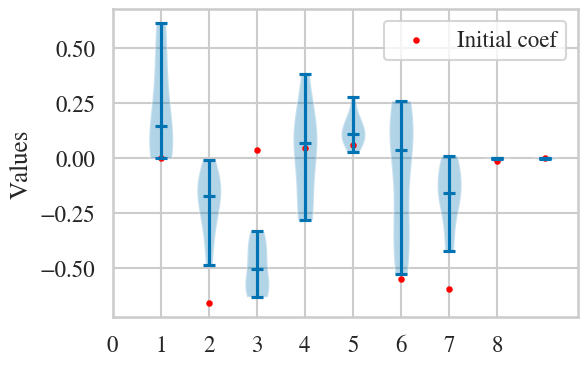

In [28]:


# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1 + np.arange(coef_treat.shape[1])  # X-axis positions of violins
y_values = coef_initial  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(np.arange(coef_treat.shape[1]))
#ax.set_xticklabels()
ax.set_ylabel("Values")
ax.legend()

plt.show()